In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-ultrasound-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209633%2F2021025%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T210729Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D587231743040d2f00df32ecafa0eba1ccbfdd6158f0894bb0af12f01bf2cd96bdc09aee1ab65010e3d32328259a3dcd59bb723c85ade9dabbaa2a0746c9d0dada8b64e3427c28ee02289eeee68d2ca18e4f6cb2778896e82878abb5735a129ca6023310e17ed8466f5f56e31f2803a95690e46a2d5e354302d27265b05b679be0266df51d04fdc18bcef3c2ccb0571b553a01c94e2fd956b37c89703e48cdb385a3ab588ac6d849134da706522fcb3687c201c04fd0c414e5e7f4e3965d48c1ee084446366c329bac9ba89f65e6361cd30debe8d6d527653f2c6a8744986f6fc2c7d369770ed9305e576b2e45bc197a659bf558bea3bb9a19f3463cec06290ae'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 204421470 bytes downloaded
Downloaded and uncompressed: breast-ultrasound-images-dataset
Data source import complete.


# <center> 💉Biomedical Image Segmentation with U-Net📈 </center>

<a id="ToC"></a>
# Table of Contents
- [1. Introduction](#1)
- [2. Imports](#2)
- [3. Data Loading and Preperation](#3)
    - [3.1 Exploring data](#3.1)
    - [3.2 Loading data](#3.2)
- [4. EDA](#4)
    - [4.1 Data of each class ](#4.1)
    - [4.2 Average view of masks each class](#4.2)
- [5. Data Pre-Processing](#5)    
- [6. Modeling](#6)
    - [6.1 Building U-Net Architecture](#6.1)
    - [6.2 Training](#6.2)
- [7. Attacking](#7)

- [8. Evaluation of Resilience to Attacking](#8)   

<a id="1"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Introduction </span></center></div>**

![](https://storage.googleapis.com/kaggle-datasets-images/1209633/2021025/67b9223181141133207afc36e35e3c5d/dataset-cover.jpg?t=2021-03-14-15-48-53)

### About Dataset

* **Breast cancer** is one of the **most common** causes of death among **women worldwide**. Early detection helps in reducing the **number of early deaths**. The data reviews the **medical images of breast cancer** using ultrasound scan. **Breast Ultrasound Dataset** is categorized into **three classes** $:$ **normal, benign, and malignant images**. **Breast ultrasound images** can produce great results in **classification, detection, and segmentation** of breast cancer when combined with machine learning.

* The data collected at baseline include **breast ultrasound images among women** in ages between 25 and 75 years old. This data was collected in **2018**. The number of patients is **600 female patients**. The dataset consists of **780 images** with an **average image size of 500*500 pixels**. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into **three classes, which are normal, benign, and malignant**.

## What is U-Net?

- **U-Net** is a popular deep-learning **architecture for semantic segmentation**. Originally developed for **medical images**, it had great success in this field. But, that was only the beginning! From satellite images to handwritten characters, the architecture has improved performance on a range of data types.
- The **U-Net architecture** has been widely used in various medical image segmentation tasks, such as **brain tumor segmentation, lung segmentation, and cell segmentation**, among others.

### U-Net: Convolutional Networks for Biomedical Image Segmentation

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

- U-net architecture (example for 32x32 pixels in the lowest resolution). Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.

- This illustration is an example of Unet architecture but layers can have different size.

**We apply it for breast cancer image segmentation with some modifications to the model.**

<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="2"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Imports </span></center></div>**

In [ ]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np
# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *

<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="3"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Data Loading and Preparation </span></center></div>**

<a id="3.1"></a>
## <span style="color:#08bf2c;"> Exploring data : </span>

In [ ]:
paths = glob('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*')

print(f'\033[92m')
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")


'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [ ]:
sorted(glob('/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/*'))[4:7]

['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100).png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask.png',
 '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png']

*** Some images have 2 or more masks. Combine them into one image.**

<a id="3.2"></a>
## <span style="color:#08bf2c;"> Loading data </span>

Functions

In [ ]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []

    x = 0   # additional variable to identify images consisting of 2 or more masks

    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image

        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask

                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [ ]:
size = 128   # image size: 128x128
X, y = load_data(root_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*',size=128)

<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="4"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> EDA </span></center></div>**

<a id="4.1"></a>
## <span style="color:#08bf2c;"> Data of each class </span>

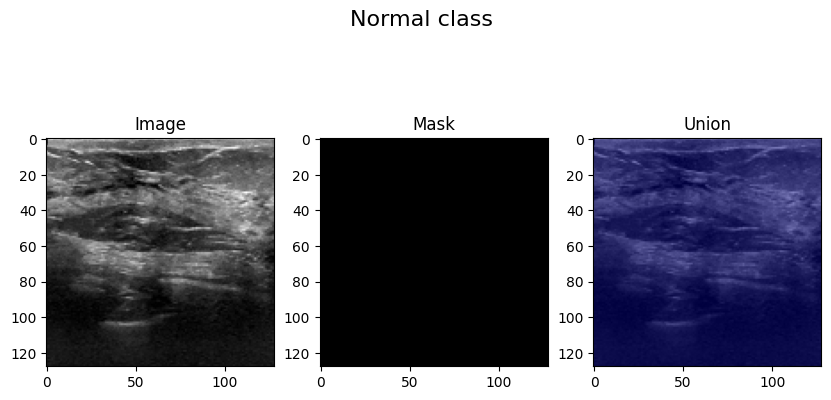

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

# X[0:437] benign
# X[437:647] malignant
# X[647:780] normal

i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

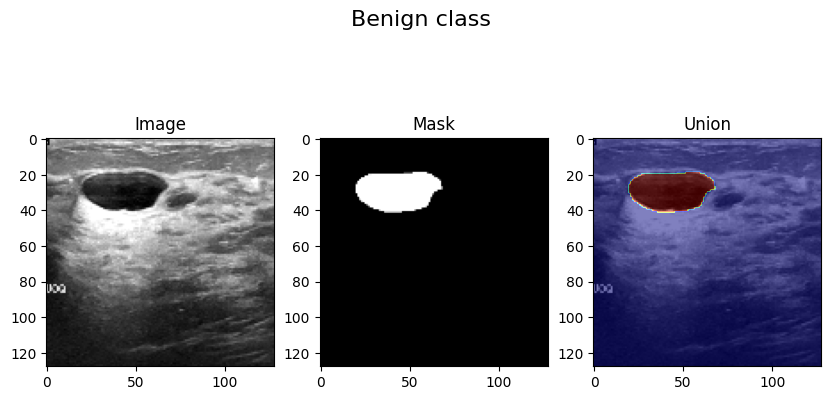

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

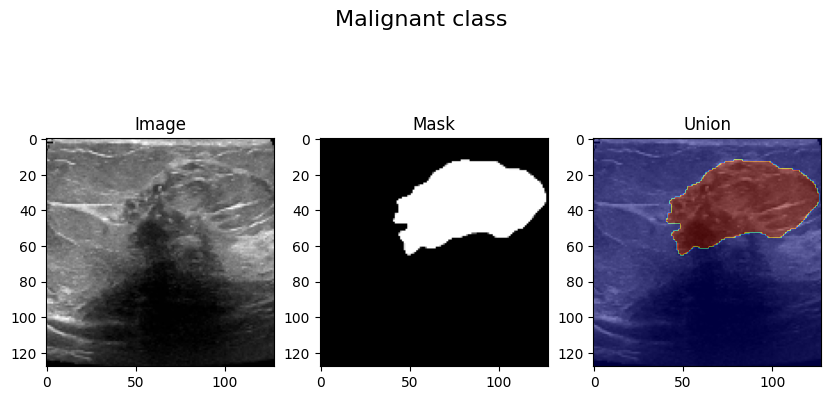

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

<a id="4.2"></a>
## <span style="color:#08bf2c;"> Average view of masks each class </span>

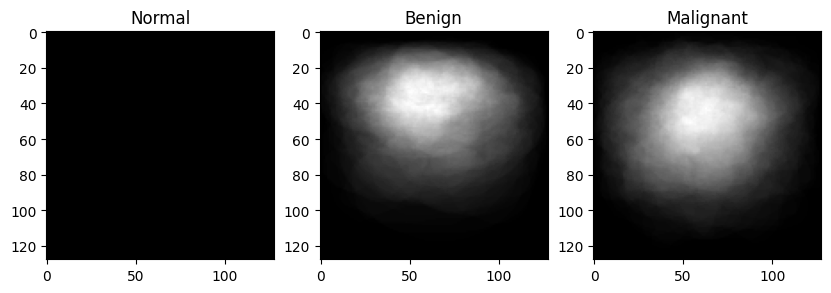

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[:437]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y[437:647]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="5"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Data Pre-Processing </span></center></div>**

### <span style="color:#2981d9;"> Prepare data to modeling </span>

In [ ]:
# drop normal class because normal class has not mask
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


### <span style="color:#2981d9;"> Train-test split </span>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (582, 128, 128, 1)
y_train shape: (582, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)


<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="6"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Modeling </span></center></div>**

<a id="6.1"></a>
## <span style="color:#08bf2c;"> Building U-Net Architecture </span>

### <span style="color:#2981d9;"> Conv block </span>

In [ ]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

### <span style="color:#2981d9;"> Encoder block </span>

In [ ]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

### <span style="color:#2981d9;"> Decoder block </span>

In [ ]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

### <span style="color:#2981d9;"> Build model </span>

In [ ]:
def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

### <span style="color:#2981d9;"> Model plotting </span>

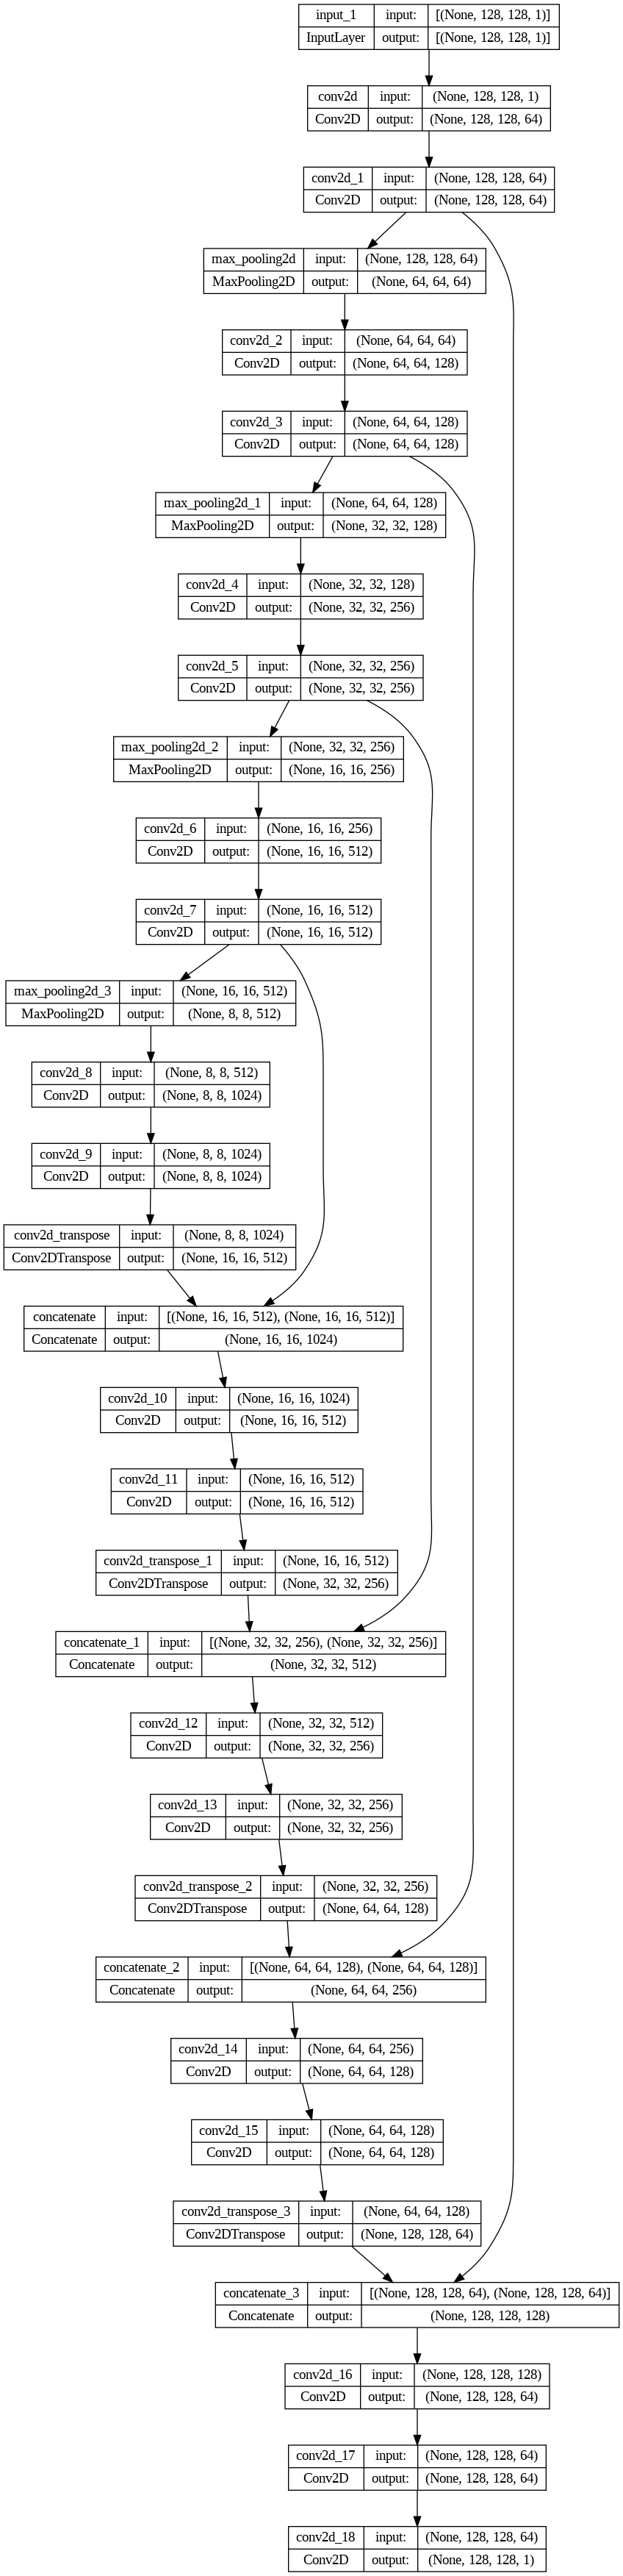

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### <span style="color:#2981d9;"> Model summary </span>

In [ ]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

<a id="6.2"></a>
## <span style="color:#08bf2c;"> Training </span>

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs = 90, validation_data = (X_test,y_test),callbacks=[early_stopping])

Epoch 1/90
19/19 [==============================] - 51s 974ms/step - loss: 0.4337 - accuracy: 0.8537 - val_loss: 0.3728 - val_accuracy: 0.9089
Epoch 2/90
19/19 [==============================] - 7s 343ms/step - loss: 0.3425 - accuracy: 0.9039 - val_loss: 0.2773 - val_accuracy: 0.9089
Epoch 3/90
19/19 [==============================] - 6s 336ms/step - loss: 0.3381 - accuracy: 0.9039 - val_loss: 0.2950 - val_accuracy: 0.9089
Epoch 4/90
19/19 [==============================] - 6s 334ms/step - loss: 0.3122 - accuracy: 0.9034 - val_loss: 0.4526 - val_accuracy: 0.9089
Epoch 5/90
19/19 [==============================] - 6s 334ms/step - loss: 0.3257 - accuracy: 0.9001 - val_loss: 0.3140 - val_accuracy: 0.9089
Epoch 6/90
19/19 [==============================] - 6s 339ms/step - loss: 0.3064 - accuracy: 0.9039 - val_loss: 0.2851 - val_accuracy: 0.9090
Epoch 7/90
19/19 [==============================] - 7s 344ms/step - loss: 0.2956 - accuracy: 0.9040 - val_loss: 0.2762 - val_accuracy: 0.9090
Epoch

In [ ]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = tf.keras.models.load_model("model.h5")

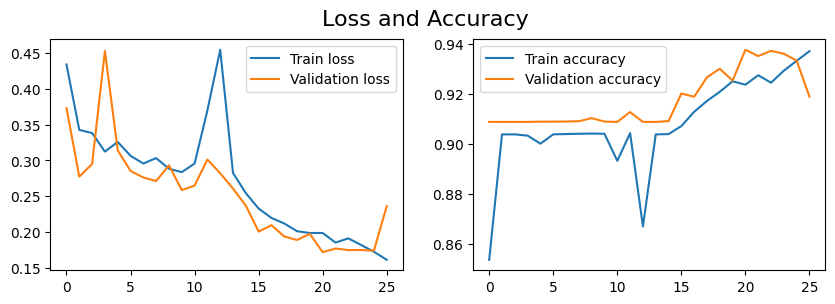

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

<a id="7"></a>
# Attacks

In [ ]:
# Function to generate adversarial examples using FGSM
import numpy as np
loss_fn = tf.keras.losses.BinaryCrossentropy()
def FGSM_attack(model, input_images,labels, epsilon=0.01):
    adversarial_examples = np.array([])
    total_length = len(input_images)
    for idx,input_image in enumerate(input_images):

        input_image = np.expand_dims(input_image, axis=0)
        input_image_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
        label=np.expand_dims(labels[idx], axis=0)
        ground_truth_labels_tensor = tf.convert_to_tensor(label, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(input_image_tensor)
#             prediction = model(input_image_tensor)
#             loss = tf.keras.losses.mean_squared_error(input_image_tensor, prediction)
            # Make predictions using the model
            predictions = model(input_image_tensor)
            # Calculate the binary cross-entropy loss
            loss = loss_fn(ground_truth_labels_tensor, predictions)
        # Get the gradients of the loss with respect to the input image
        gradient = tape.gradient(loss, input_image_tensor)

        # Compute the sign of the gradient
        signed_grad = tf.sign(gradient)

        # Create the adversarial image by perturbing the input image
        adversarial_image = input_image_tensor + epsilon * signed_grad

        # Clip the adversarial image to ensure it stays within valid pixel range
        adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)

        # Convert adversarial_image to NumPy array
        adversarial_image_np = adversarial_image.numpy()

        # Stack adversarial_image if adversarial_examples is not empty
        if adversarial_examples.size == 0:
            adversarial_examples = adversarial_image_np
        else:
            adversarial_examples = np.concatenate((adversarial_examples,adversarial_image_np),axis=0)
        dl = (idx + 1) * len(input_image)
        done = int(50 * dl / total_length)
        sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} FGSM Attacked!")
        sys.stdout.flush()
    print("\nDone!")
    return adversarial_examples

adversarial_examples_fgsm = FGSM_attack(model, X_test,y_test, epsilon=0.1)


[==================================================] 65 FGSM Attacked!
Done!


In [ ]:
import tensorflow as tf
import numpy as np

def bim_attack(model, input_images,labels, epsilon=0.01, num_steps=10):
    epsilon_step=epsilon/10
    adversarial_examples = np.array([])
    total_length = len(input_images)
    for idx, input_image in enumerate(input_images):
        x=0
        input_image = np.expand_dims(input_image, axis=0)
        input_image_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
        label=np.expand_dims(labels[idx], axis=0)
        ground_truth_labels_tensor = tf.convert_to_tensor(label, dtype=tf.float32)
        adversarial_image = input_image_tensor  # Initialize adversarial image with original image
        for _ in range(num_steps):

            with tf.GradientTape() as tape:
                tape.watch(adversarial_image)
#                 prediction = model(input_image_tensor
                predictions = model(adversarial_image)
                # Calculate the binary cross-entropy loss
                # print(ground_truth_labels_tensor.shape)
                # print(predictions.shape)
                # print(input_image_tensor.shape)

                loss = loss_fn(ground_truth_labels_tensor, predictions)
                print(loss)
#                 prediction = model(input_image_tensor)
#                 print(prediction.shape)
#                 loss = tf.keras.losses.mean_squared_error(input_image_tensor, prediction)

            # Get the gradients of the loss with respect to the input image
            gradient = tape.gradient(loss,adversarial_image)

            # Compute the sign of the gradient
            signed_grad = tf.sign(gradient)

            # Create the adversarial image by perturbing the input image
            adversarial_image = adversarial_image  + epsilon_step * signed_grad

            # Clip the adversarial image to ensure it stays within valid pixel range
            adversarial_image = tf.clip_by_value(adversarial_image ,input_image_tensor - epsilon, input_image_tensor + epsilon)
            adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)

            # Convert adversarial_image to NumPy array
            adversarial_image_np = adversarial_image.numpy()

            # Stack adversarial_image if adversarial_examples is not empty
        if adversarial_examples.size == 0:

            adversarial_examples = adversarial_image_np
        else:

            adversarial_examples = np.concatenate((adversarial_examples, adversarial_image_np), axis=0)
        dl = (idx + 1) * len(input_image)
        done = int(50 * dl / total_length)
        sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} BIM Attacked!")
        sys.stdout.flush()
    print("\nDone!")

    return adversarial_examples


adversarial_examples_bim = bim_attack(model, X_test,y_test,epsilon=0.1,  num_steps=10)


tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.06534879, shape=(), dtype=float32)
tf.Tensor(0.07485095, shape=(), dtype=float32)
tf.Tensor(0.08522162, shape=(), dtype=float32)
tf.Tensor(0.09672746, shape=(), dtype=float32)
tf.Tensor(0.10985489, shape=(), dtype=float32)
tf.Tensor(0.12519547, shape=(), dtype=float32)
tf.Tensor(0.14276792, shape=(), dtype=float32)
tf.Tensor(0.16349845, shape=(), dtype=float32)
tf.Tensor(0.18707493, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.10257052, shape=(), dtype=float32)
tf.Tensor(0.114062145, shape=(), dtype=float32)
tf.Tensor(0.12758245, shape=(), dtype=float32)
tf.Tensor(0.14352667, shape=(), dtype=float32)
tf.Tensor(0.16239515, shape=(), dtype=float32)
tf.Tensor(0.18442899, shape=(), dtype=float32)
tf.Tensor(0.20964155, shape=(), dtype=float32)
tf.Tensor(0.23791656, shape=(), dtype=float32)
tf.Tensor(0.26951048, shape=(), dtyp

In [ ]:
import tensorflow as tf
import numpy as np

def pgd_attack(model, input_images, labels, epsilon=0.01,  num_steps=10):
    alpha=epsilon/4
    adversarial_examples = np.array([])
    total_length = len(input_images)
    for idx, input_image in enumerate(input_images):
        input_image = np.expand_dims(input_image, axis=0)
        label=np.expand_dims(labels[idx], axis=0)
        input_image_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
        ground_truth_labels_tensor = tf.convert_to_tensor(label, dtype=tf.float32)
        adversarial_image = input_image_tensor + tf.random.uniform(input_image_tensor.shape, -epsilon, epsilon)  # Initialize adversarial image with original image
        for _ in range(num_steps):
            with tf.GradientTape() as tape:
                tape.watch(adversarial_image)
                predictions = model(adversarial_image)
                loss = loss_fn(ground_truth_labels_tensor, predictions)
                print(loss)

            # Get the gradients of the loss with respect to the adversarial image
            gradient = tape.gradient(loss, adversarial_image)
            # Compute the sign of the gradient
            signed_grad = tf.sign(gradient)

            # Update the adversarial image using the gradient and step size
            adversarial_image = adversarial_image + alpha * signed_grad

            # Project the adversarial image back onto the L-infinity norm ball centered around the original image
            perturbation = adversarial_image - input_image_tensor
            perturbation = tf.clip_by_value(perturbation, -epsilon, epsilon)
            adversarial_image = tf.clip_by_value(input_image_tensor + perturbation, 0, 1)

        # Convert adversarial_image to NumPy array
        adversarial_image_np = adversarial_image.numpy()

        # Stack adversarial_image if adversarial_examples is not empty
        if adversarial_examples.size == 0:
            adversarial_examples = adversarial_image_np
        else:
            adversarial_examples = np.concatenate((adversarial_examples, adversarial_image_np), axis=0)

        dl = (idx + 1) * len(input_image)
        done = int(50 * dl / total_length)
        sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} PGD Attacked!")
        sys.stdout.flush()

    print("\nDone!")

    return adversarial_examples
adversarial_examples_pgd = pgd_attack(model, X_test,y_test,epsilon=0.1, num_steps=10)

tf.Tensor(0.06036662, shape=(), dtype=float32)
tf.Tensor(0.08222377, shape=(), dtype=float32)
tf.Tensor(0.1048, shape=(), dtype=float32)
tf.Tensor(0.12871662, shape=(), dtype=float32)
tf.Tensor(0.15258965, shape=(), dtype=float32)
tf.Tensor(0.17569485, shape=(), dtype=float32)
tf.Tensor(0.19580384, shape=(), dtype=float32)
tf.Tensor(0.2108848, shape=(), dtype=float32)
tf.Tensor(0.21984014, shape=(), dtype=float32)
tf.Tensor(0.22492763, shape=(), dtype=float32)
[                                                  ] 1 PGD Attacked!tf.Tensor(0.09597072, shape=(), dtype=float32)
tf.Tensor(0.12335855, shape=(), dtype=float32)
tf.Tensor(0.15583774, shape=(), dtype=float32)
tf.Tensor(0.19148332, shape=(), dtype=float32)
tf.Tensor(0.22654217, shape=(), dtype=float32)
tf.Tensor(0.25770837, shape=(), dtype=float32)
tf.Tensor(0.28191084, shape=(), dtype=float32)
tf.Tensor(0.2992385, shape=(), dtype=float32)
tf.Tensor(0.30914402, shape=(), dtype=float32)
tf.Tensor(0.3145247, shape=(), dtype=float32)

In [ ]:
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU of X test =", IOU_keras.result().numpy())

Mean IoU of X test = 0.66656303


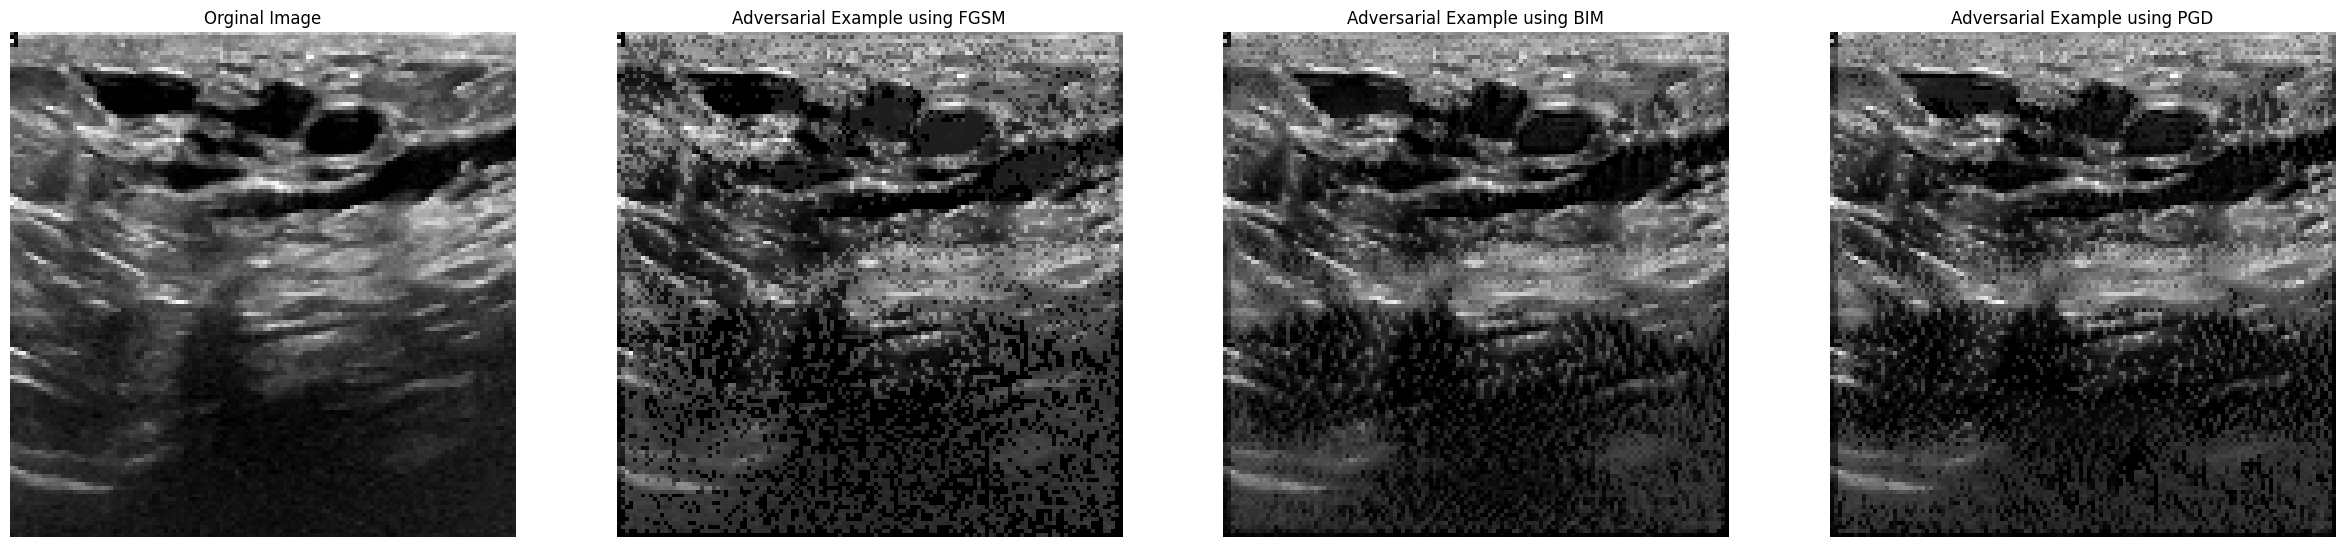

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(30, 10))
axes[0].imshow(X_test[3], cmap='gray')
axes[0].set_title('Orginal Image')
axes[0].axis('off')
axes[1].imshow(adversarial_examples_fgsm[3], cmap='gray')
axes[1].set_title('Adversarial Example using FGSM')
axes[1].axis('off')
axes[2].imshow(adversarial_examples_bim[3], cmap='gray')
axes[2].set_title('Adversarial Example using BIM')
axes[2].axis('off')
axes[3].imshow(adversarial_examples_pgd[3], cmap='gray')
axes[3].set_title('Adversarial Example using PGD')
axes[3].axis('off')
plt.show()

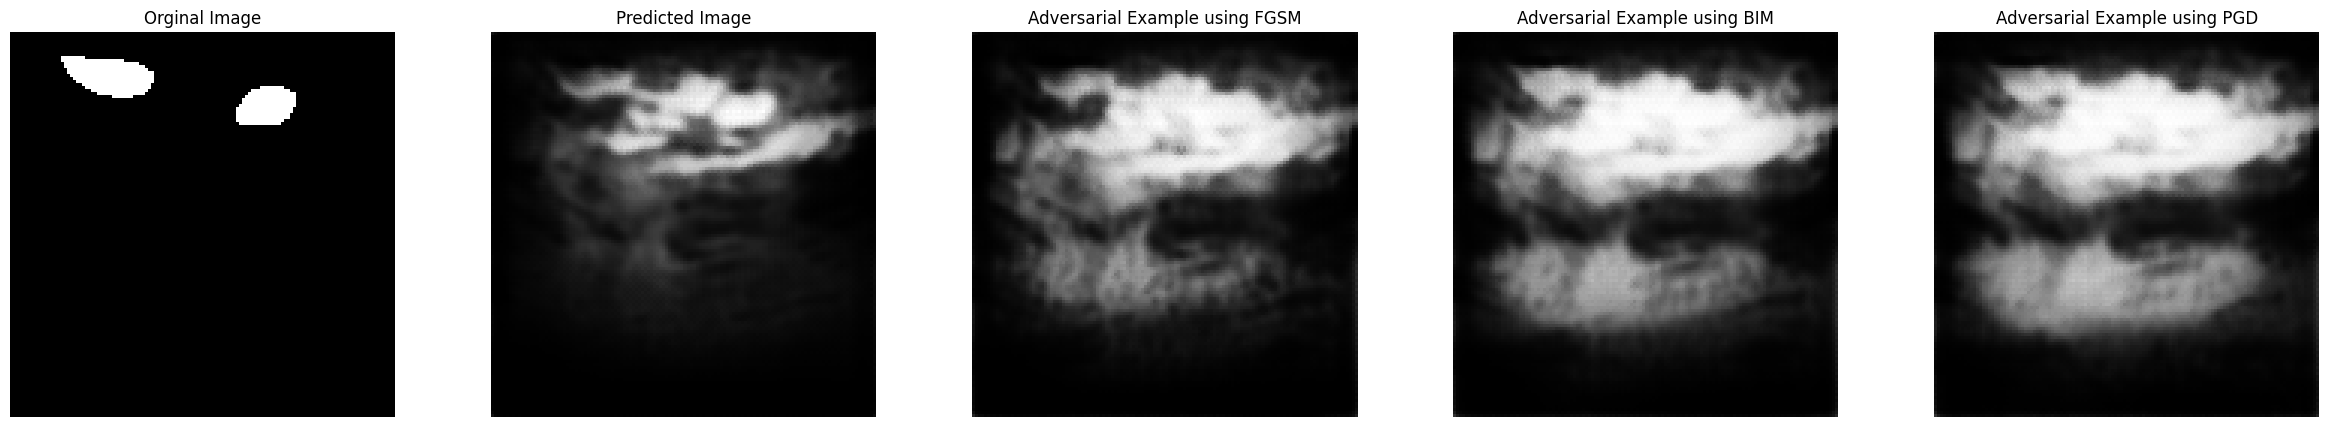

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(30, 5))
axes[0].imshow(y_test[3], cmap='gray')
axes[0].set_title('Orginal Image')
axes[0].axis('off')
axes[1].imshow(model.predict(np.expand_dims(X_test[3],0),verbose=0)[0], cmap='gray')
axes[1].set_title('Predicted Image')
axes[1].axis('off')
axes[2].imshow(model.predict(adversarial_examples_fgsm,verbose=0)[3], cmap='gray')
axes[2].set_title('Adversarial Example using FGSM')
axes[2].axis('off')
axes[3].imshow(model.predict(adversarial_examples_bim,verbose=0)[3], cmap='gray')
axes[3].set_title('Adversarial Example using BIM')
axes[3].axis('off')
axes[4].imshow(model.predict(adversarial_examples_pgd,verbose=0)[3], cmap='gray')
axes[4].set_title('Adversarial Example using PGD')
axes[4].axis('off')
plt.show()

In [ ]:
def ploting_all(x,y,z,o,ep):
  fig, axes = plt.subplots(1, 5, figsize=(30, 5))
  plt.suptitle(f'Epsilon: {ep}', fontsize=16)
  axes[0].imshow(y_test[3], cmap='gray')
  axes[0].set_title('Orginal Image')
  axes[0].axis('off')
  axes[1].imshow(model.predict(np.expand_dims(o[3],0),verbose=0)[0], cmap='gray')
  axes[1].set_title('Predicted Image')
  axes[1].axis('off')
  axes[2].imshow(model.predict(x,verbose=0)[3], cmap='gray')
  axes[2].set_title('Adversarial Example using FGSM')
  axes[2].axis('off')
  axes[3].imshow(model.predict(y,verbose=0)[3], cmap='gray')
  axes[3].set_title('Adversarial Example using BIM')
  axes[3].axis('off')
  axes[4].imshow(model.predict(z,verbose=0)[3], cmap='gray')
  axes[4].set_title('Adversarial Example using PGD')
  axes[4].axis('off')

  plt.show()

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 1s 65ms/step - loss: 0.1739 - accuracy: 0.9370
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.05705823, shape=(), dtype=float32)
tf.Tensor(0.057137433, shape=(), dtype=float32)
tf.Tensor(0.057216913, shape=(), dtype=float32)
tf.Tensor(0.05729647, shape=(), dtype=float32)
tf.Tensor(0.057375923, shape=(), dtype=float32)
tf.Tensor(0.05745538, shape=(), dtype=float32)
tf.Tensor(0.05753564, shape=(), dtype=float32)
tf.Tensor(0.057616137, shape=(), dtype=float32)
tf.Tensor(0.05769678, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.092751116, shape=(), dtype=float32)
tf.Tensor(0.092847094, shape=(), dtype=float32)
tf.Tensor(0.09294316, shape=(), dtype=float32)
tf.Tensor(0.09303947, shape=(), dtype=float32)
tf.Tensor(0.09313582, shape=(), dtype=float32)
tf.Tensor

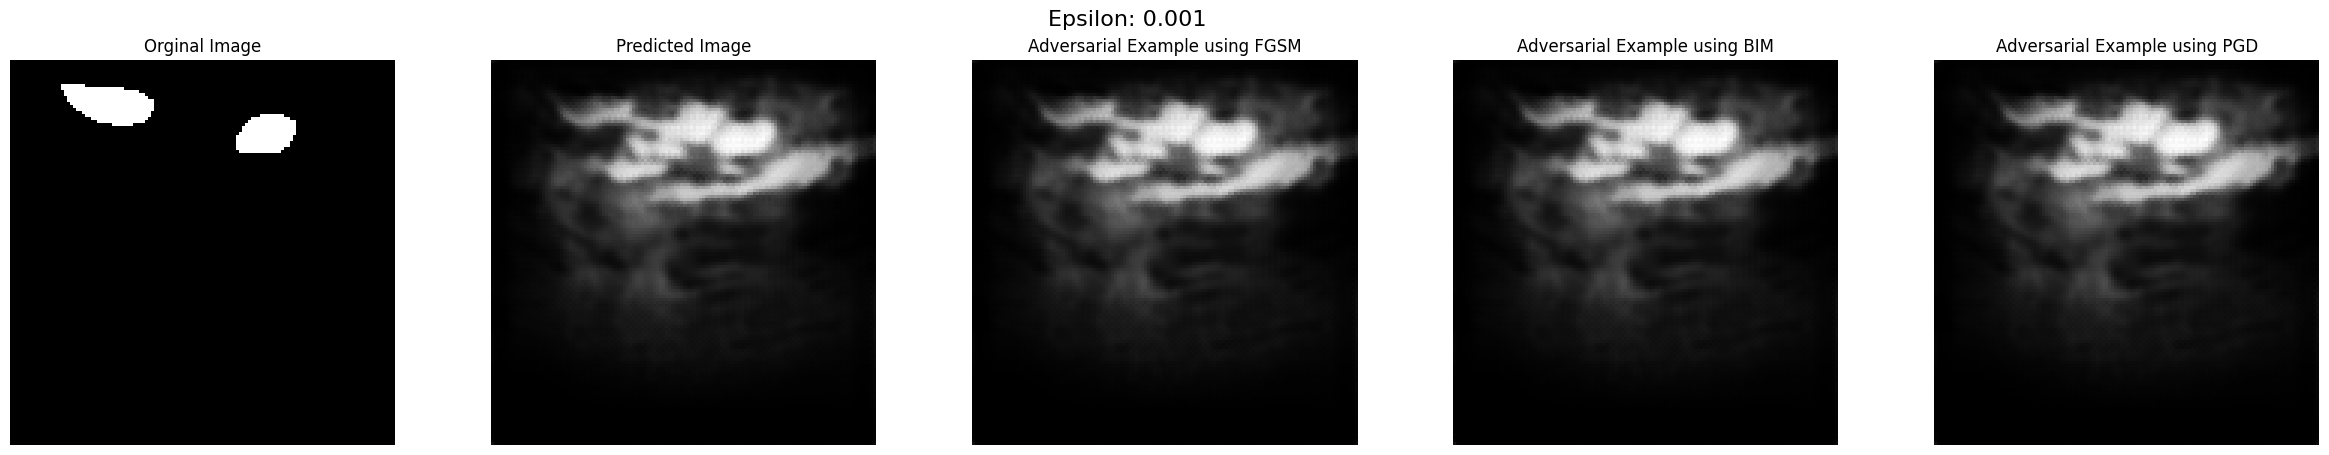

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 65ms/step - loss: 0.1758 - accuracy: 0.9363
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.05713739, shape=(), dtype=float32)
tf.Tensor(0.05729642, shape=(), dtype=float32)
tf.Tensor(0.057455294, shape=(), dtype=float32)
tf.Tensor(0.057616018, shape=(), dtype=float32)
tf.Tensor(0.057777457, shape=(), dtype=float32)
tf.Tensor(0.057939284, shape=(), dtype=float32)
tf.Tensor(0.05810095, shape=(), dtype=float32)
tf.Tensor(0.05826258, shape=(), dtype=float32)
tf.Tensor(0.058424912, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.092847064, shape=(), dtype=float32)
tf.Tensor(0.093039416, shape=(), dtype=float32)
tf.Tensor(0.09323208, shape=(), dtype=float32)
tf.Tensor(0.09342515, shape=(), dtype=float32)
tf.Tensor(0.09361887, shape=(), dtype=float32)
tf.Tenso

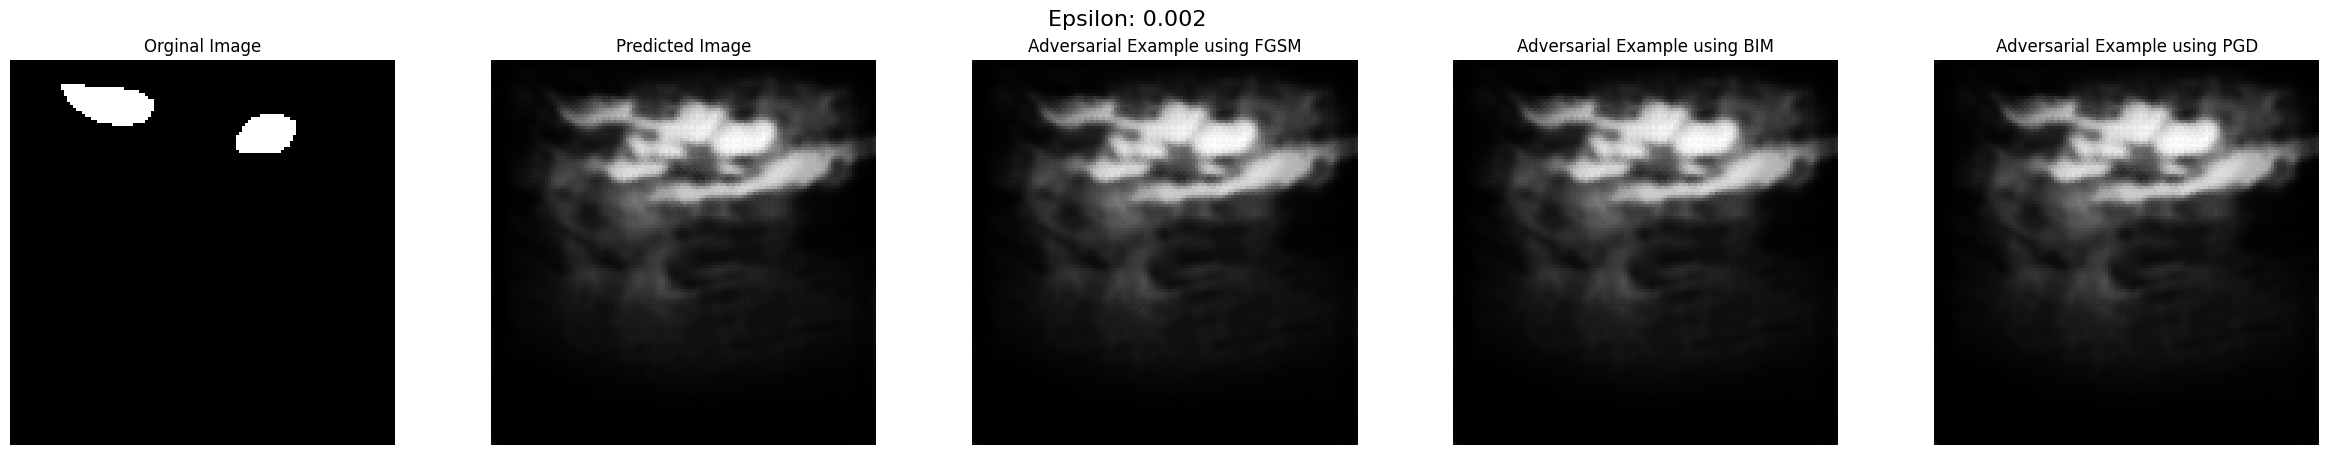

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 65ms/step - loss: 0.1778 - accuracy: 0.9356
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.05721679, shape=(), dtype=float32)
tf.Tensor(0.057455197, shape=(), dtype=float32)
tf.Tensor(0.057696432, shape=(), dtype=float32)
tf.Tensor(0.057939082, shape=(), dtype=float32)
tf.Tensor(0.0581815, shape=(), dtype=float32)
tf.Tensor(0.0584244, shape=(), dtype=float32)
tf.Tensor(0.058668897, shape=(), dtype=float32)
tf.Tensor(0.058913983, shape=(), dtype=float32)
tf.Tensor(0.05915965, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.092943, shape=(), dtype=float32)
tf.Tensor(0.09323201, shape=(), dtype=float32)
tf.Tensor(0.09352178, shape=(), dtype=float32)
tf.Tensor(0.093812585, shape=(), dtype=float32)
tf.Tensor(0.09410328, shape=(), dtype=float32)
tf.Tensor(0.0

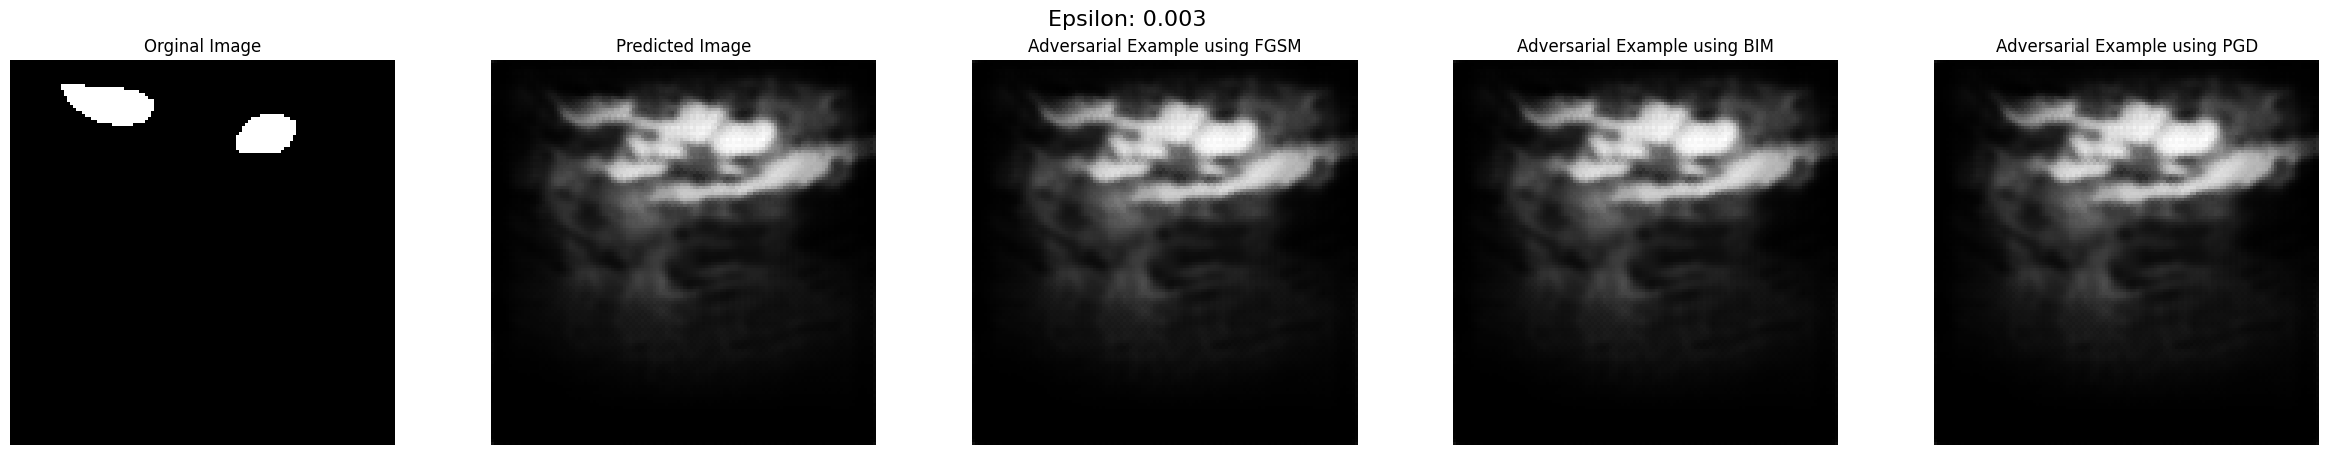

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 65ms/step - loss: 0.1797 - accuracy: 0.9350
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.057296306, shape=(), dtype=float32)
tf.Tensor(0.05761575, shape=(), dtype=float32)
tf.Tensor(0.057938937, shape=(), dtype=float32)
tf.Tensor(0.05826192, shape=(), dtype=float32)
tf.Tensor(0.058586985, shape=(), dtype=float32)
tf.Tensor(0.05891358, shape=(), dtype=float32)
tf.Tensor(0.059241116, shape=(), dtype=float32)
tf.Tensor(0.059570745, shape=(), dtype=float32)
tf.Tensor(0.059903093, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.093039215, shape=(), dtype=float32)
tf.Tensor(0.09342484, shape=(), dtype=float32)
tf.Tensor(0.09381226, shape=(), dtype=float32)
tf.Tensor(0.094199516, shape=(), dtype=float32)
tf.Tensor(0.09458761, shape=(), dtype=float32)
tf.Tens

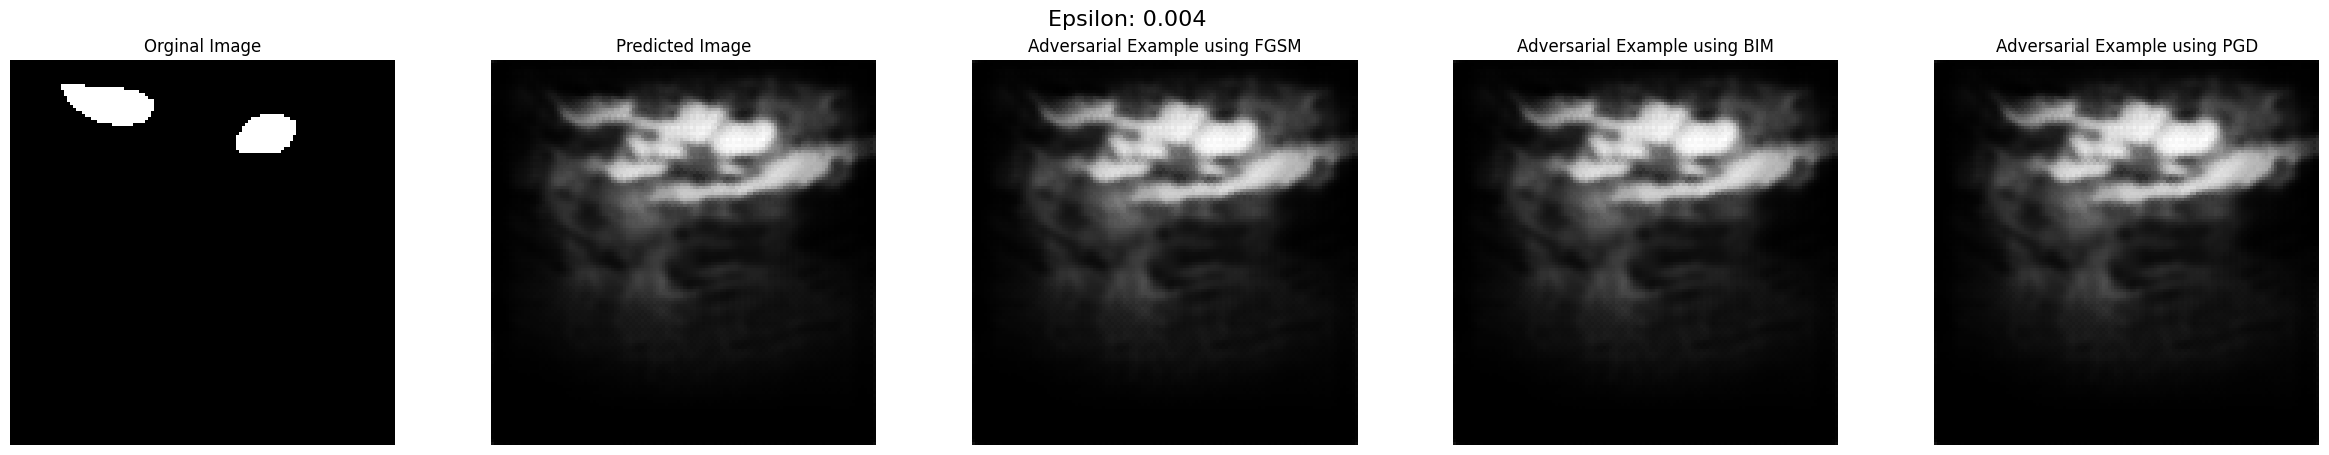

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 64ms/step - loss: 0.1815 - accuracy: 0.9343
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.05737564, shape=(), dtype=float32)
tf.Tensor(0.0577769, shape=(), dtype=float32)
tf.Tensor(0.05818087, shape=(), dtype=float32)
tf.Tensor(0.05858643, shape=(), dtype=float32)
tf.Tensor(0.05899487, shape=(), dtype=float32)
tf.Tensor(0.05940512, shape=(), dtype=float32)
tf.Tensor(0.059819374, shape=(), dtype=float32)
tf.Tensor(0.06023788, shape=(), dtype=float32)
tf.Tensor(0.06066129, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.09313539, shape=(), dtype=float32)
tf.Tensor(0.09361835, shape=(), dtype=float32)
tf.Tensor(0.09410266, shape=(), dtype=float32)
tf.Tensor(0.09458721, shape=(), dtype=float32)
tf.Tensor(0.09507452, shape=(), dtype=float32)
tf.Tensor(0.095

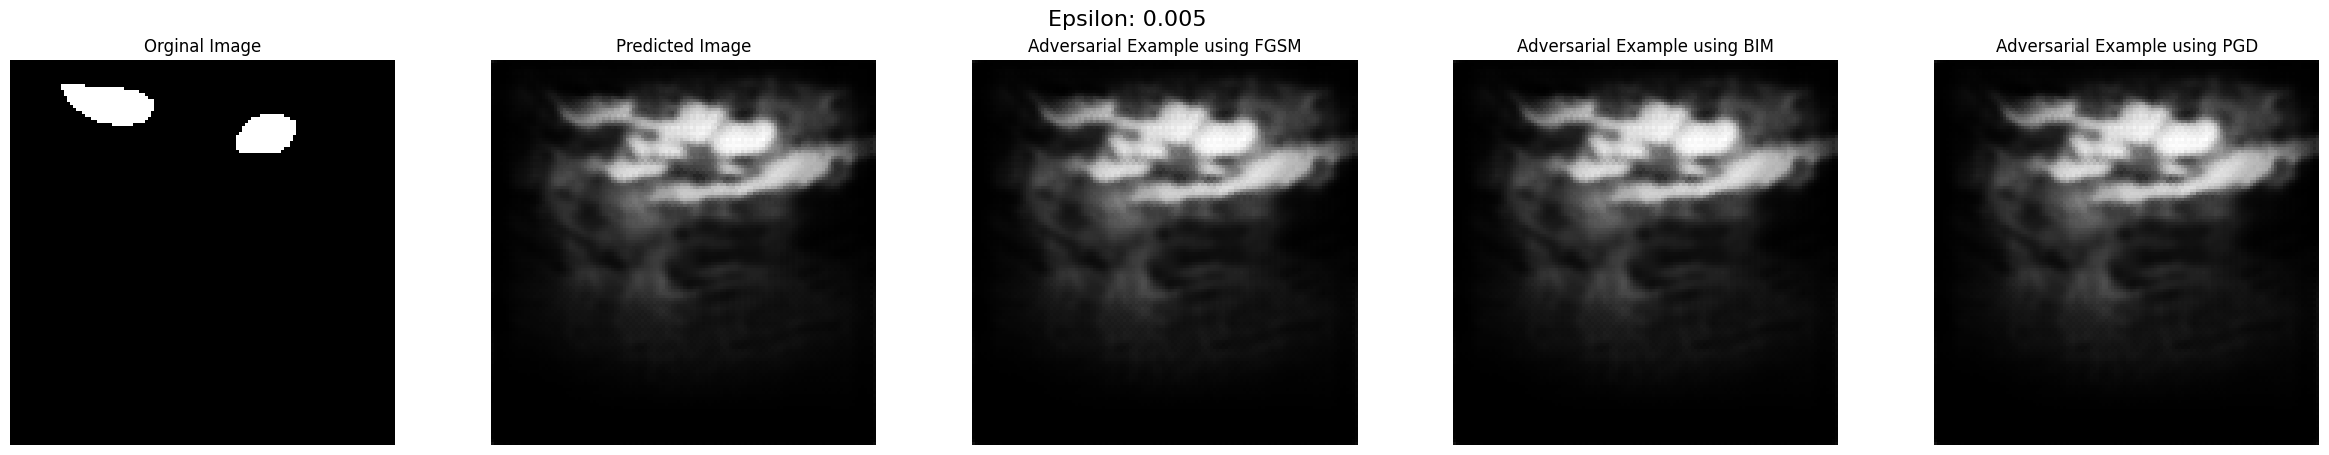

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 65ms/step - loss: 0.1833 - accuracy: 0.9337
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.05745495, shape=(), dtype=float32)
tf.Tensor(0.057938524, shape=(), dtype=float32)
tf.Tensor(0.058423385, shape=(), dtype=float32)
tf.Tensor(0.058912717, shape=(), dtype=float32)
tf.Tensor(0.059404448, shape=(), dtype=float32)
tf.Tensor(0.05990177, shape=(), dtype=float32)
tf.Tensor(0.060404785, shape=(), dtype=float32)
tf.Tensor(0.060915485, shape=(), dtype=float32)
tf.Tensor(0.061431486, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.093231596, shape=(), dtype=float32)
tf.Tensor(0.093811825, shape=(), dtype=float32)
tf.Tensor(0.094392285, shape=(), dtype=float32)
tf.Tensor(0.09497592, shape=(), dtype=float32)
tf.Tensor(0.09556559, shape=(), dtype=float32)
tf.Te

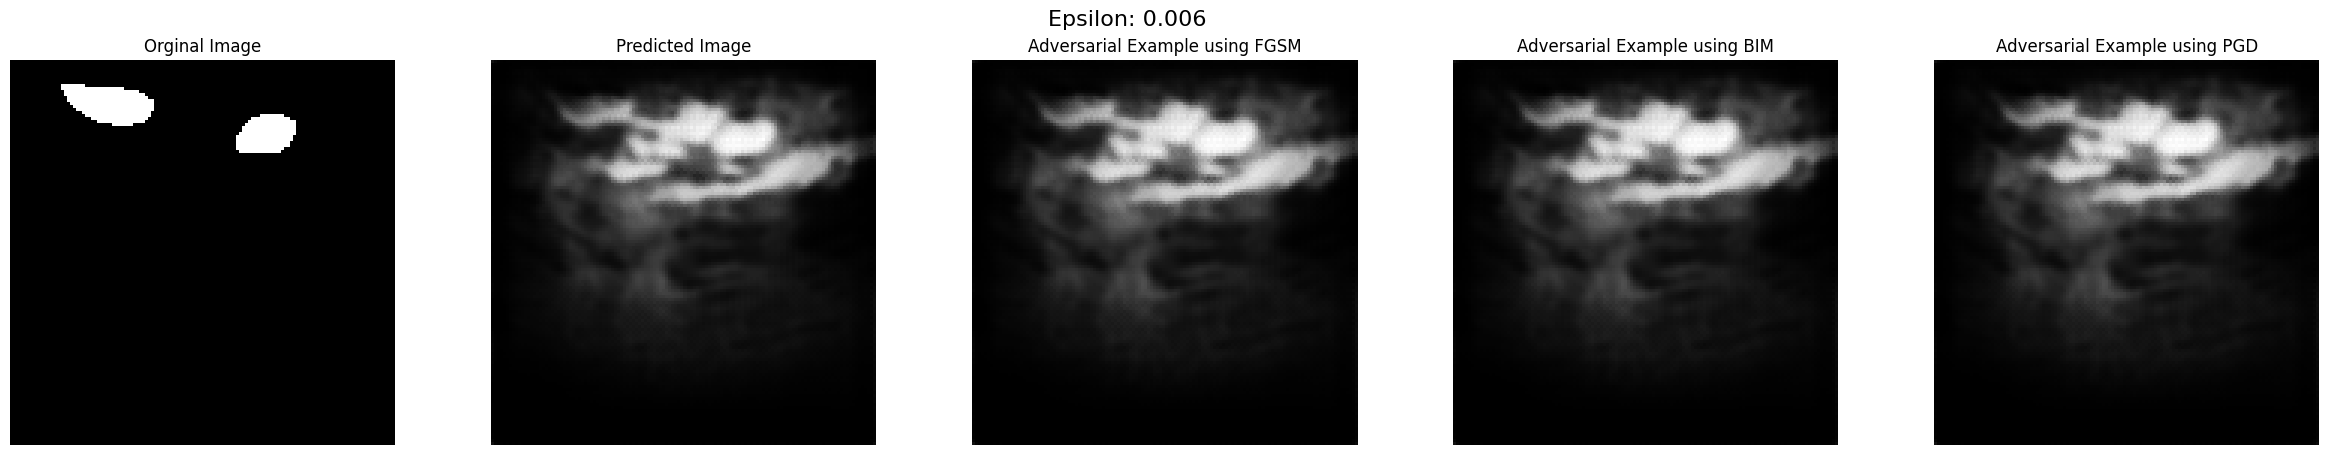

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 66ms/step - loss: 0.1850 - accuracy: 0.9331
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.057534933, shape=(), dtype=float32)
tf.Tensor(0.05809966, shape=(), dtype=float32)
tf.Tensor(0.05866726, shape=(), dtype=float32)
tf.Tensor(0.059239745, shape=(), dtype=float32)
tf.Tensor(0.059817467, shape=(), dtype=float32)
tf.Tensor(0.06040425, shape=(), dtype=float32)
tf.Tensor(0.061000235, shape=(), dtype=float32)
tf.Tensor(0.061604053, shape=(), dtype=float32)
tf.Tensor(0.06221707, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.09332776, shape=(), dtype=float32)
tf.Tensor(0.09400511, shape=(), dtype=float32)
tf.Tensor(0.09468348, shape=(), dtype=float32)
tf.Tensor(0.09536773, shape=(), dtype=float32)
tf.Tensor(0.096061215, shape=(), dtype=float32)
tf.Tensor

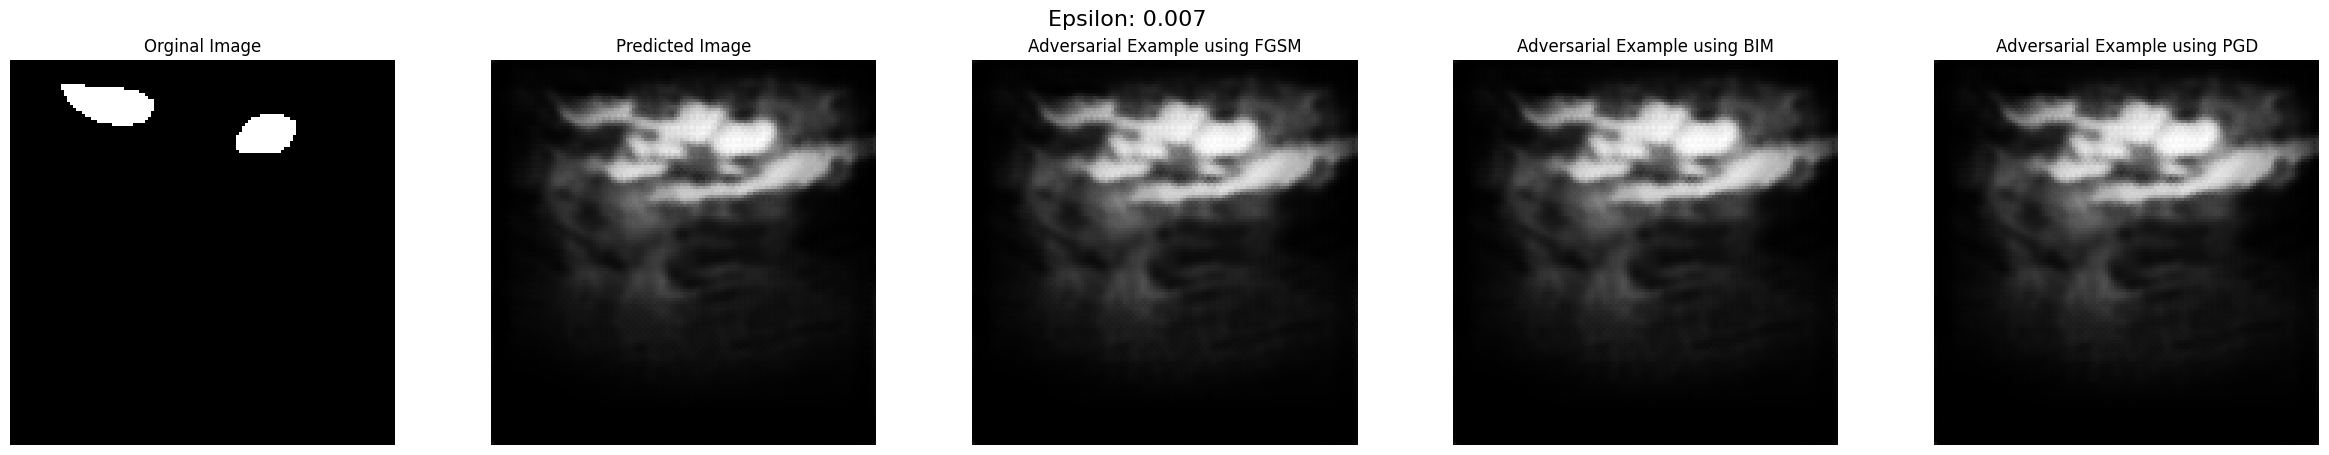

In [ ]:
perturbation_3 = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
FGSM_accuracy_3 = []
PGD_accuracy_3 = []
BIM_accuracy_3 = []
FGSM_loss_3=[]
BIM_loss_3=[]
PGD_loss_3=[]

for i in perturbation_3:

  _fgsm = FGSM_attack(model, X_test,y_test,epsilon=i)
  loss, accuracy=model.evaluate(_fgsm ,y_test )
  FGSM_accuracy_3.append(accuracy)
  FGSM_loss_3.append(loss)

  _bim = bim_attack(model, X_test,y_test,epsilon=i, num_steps=10)
  loss, accuracy=model.evaluate(_bim ,y_test )
  BIM_accuracy_3.append(accuracy)
  BIM_loss_3.append(loss)

  _pgd = pgd_attack(model, X_test,y_test,epsilon=i, num_steps=10)
  loss, accuracy=model.evaluate(_pgd ,y_test )
  PGD_accuracy_3.append(accuracy)
  PGD_loss_3.append(loss)

  ploting_all(_fgsm,_bim,_pgd,X_test,i)

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 65ms/step - loss: 0.1903 - accuracy: 0.9310
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.057775974, shape=(), dtype=float32)
tf.Tensor(0.0585844, shape=(), dtype=float32)
tf.Tensor(0.05940207, shape=(), dtype=float32)
tf.Tensor(0.060233094, shape=(), dtype=float32)
tf.Tensor(0.06108223, shape=(), dtype=float32)
tf.Tensor(0.061949316, shape=(), dtype=float32)
tf.Tensor(0.0628353, shape=(), dtype=float32)
tf.Tensor(0.063736424, shape=(), dtype=float32)
tf.Tensor(0.06464739, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.09361711, shape=(), dtype=float32)
tf.Tensor(0.09458471, shape=(), dtype=float32)
tf.Tensor(0.09556281, shape=(), dtype=float32)
tf.Tensor(0.096559, shape=(), dtype=float32)
tf.Tensor(0.09756764, shape=(), dtype=float32)
tf.Tensor(0.098

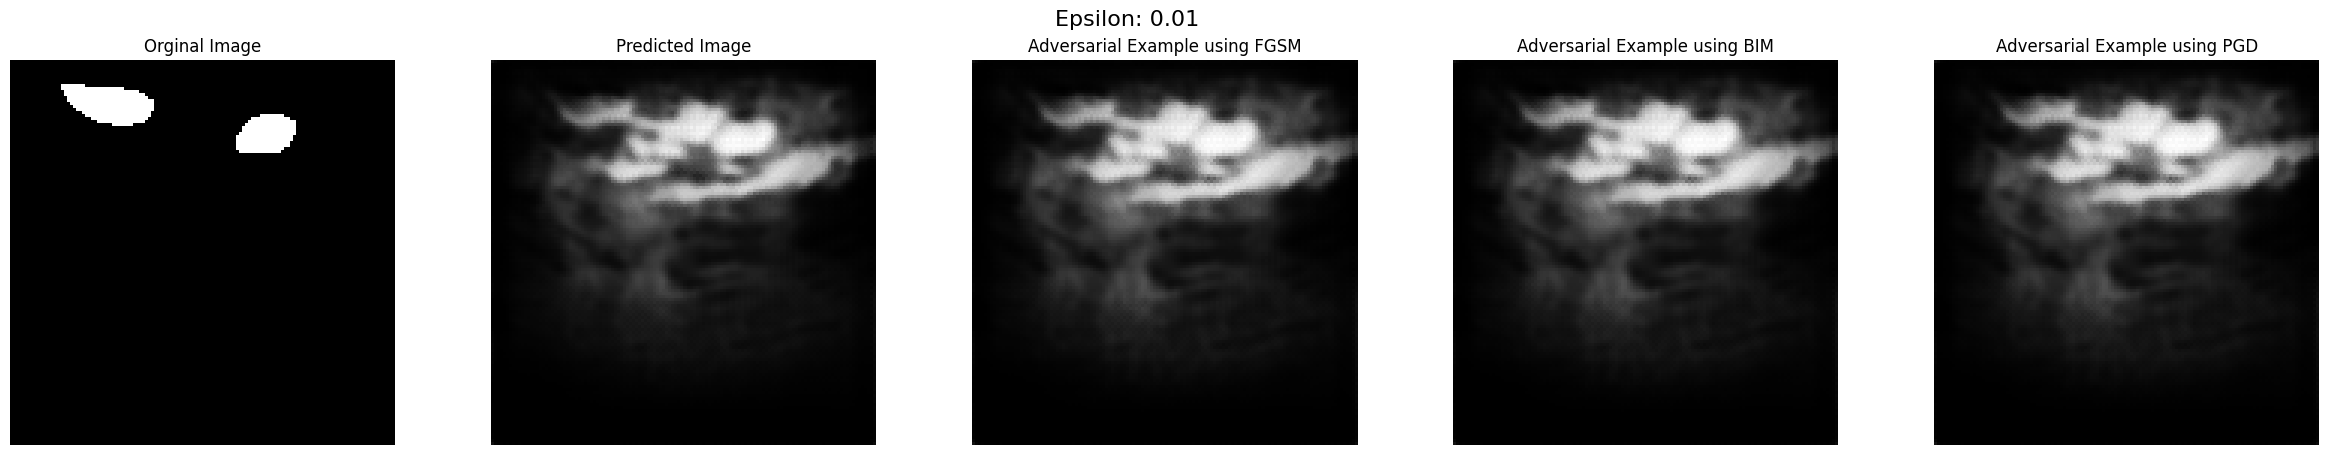

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 65ms/step - loss: 0.2073 - accuracy: 0.9237
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.058580868, shape=(), dtype=float32)
tf.Tensor(0.060226545, shape=(), dtype=float32)
tf.Tensor(0.061937667, shape=(), dtype=float32)
tf.Tensor(0.06372211, shape=(), dtype=float32)
tf.Tensor(0.065549485, shape=(), dtype=float32)
tf.Tensor(0.06742175, shape=(), dtype=float32)
tf.Tensor(0.069336735, shape=(), dtype=float32)
tf.Tensor(0.07128878, shape=(), dtype=float32)
tf.Tensor(0.073283255, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.094580196, shape=(), dtype=float32)
tf.Tensor(0.09654829, shape=(), dtype=float32)
tf.Tensor(0.098571874, shape=(), dtype=float32)
tf.Tensor(0.10064209, shape=(), dtype=float32)
tf.Tensor(0.10276387, shape=(), dtype=float32)
tf.Tens

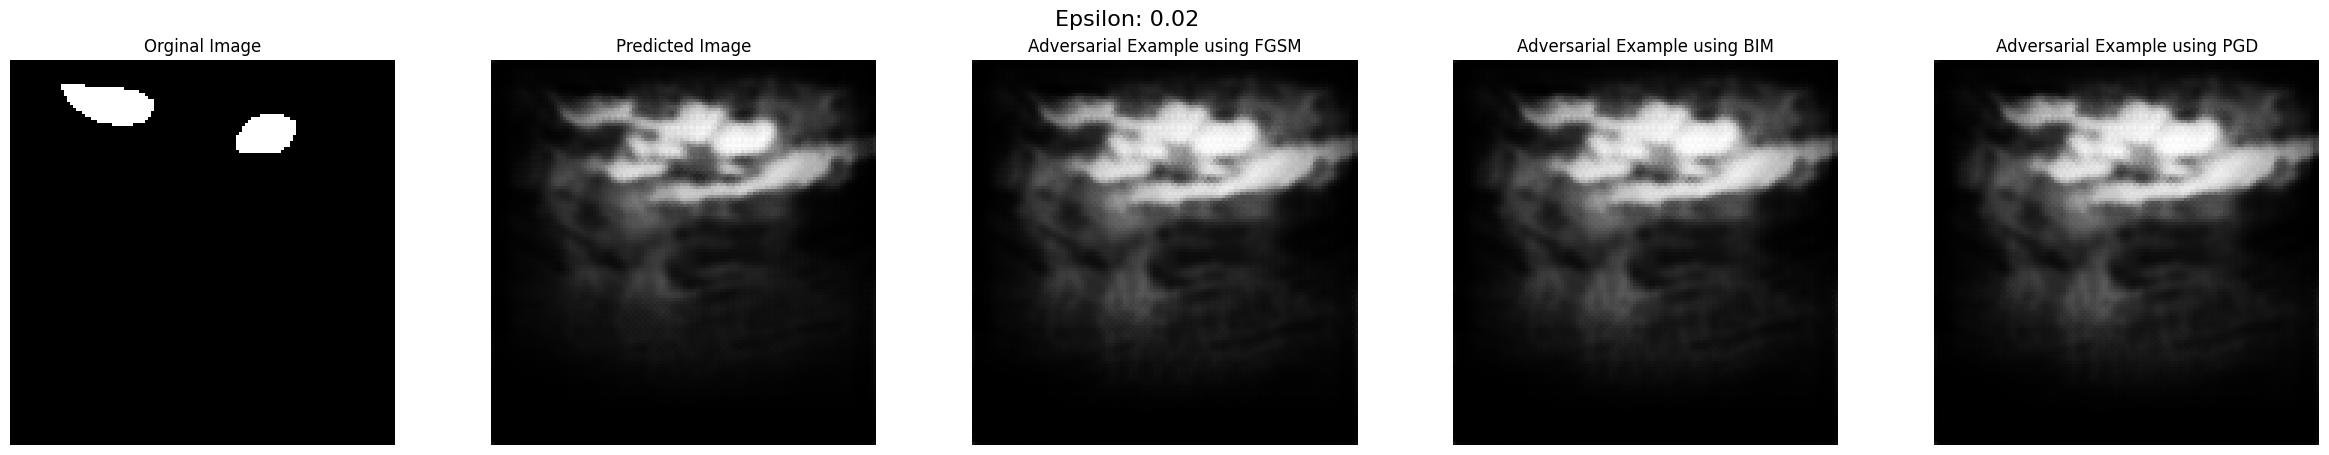

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 66ms/step - loss: 0.2239 - accuracy: 0.9159
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.05939011, shape=(), dtype=float32)
tf.Tensor(0.061925218, shape=(), dtype=float32)
tf.Tensor(0.06461191, shape=(), dtype=float32)
tf.Tensor(0.06739564, shape=(), dtype=float32)
tf.Tensor(0.07026912, shape=(), dtype=float32)
tf.Tensor(0.07323596, shape=(), dtype=float32)
tf.Tensor(0.076286584, shape=(), dtype=float32)
tf.Tensor(0.07939768, shape=(), dtype=float32)
tf.Tensor(0.082606, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.09554888, shape=(), dtype=float32)
tf.Tensor(0.098558635, shape=(), dtype=float32)
tf.Tensor(0.101678886, shape=(), dtype=float32)
tf.Tensor(0.10493722, shape=(), dtype=float32)
tf.Tensor(0.10838102, shape=(), dtype=float32)
tf.Tensor(0.1

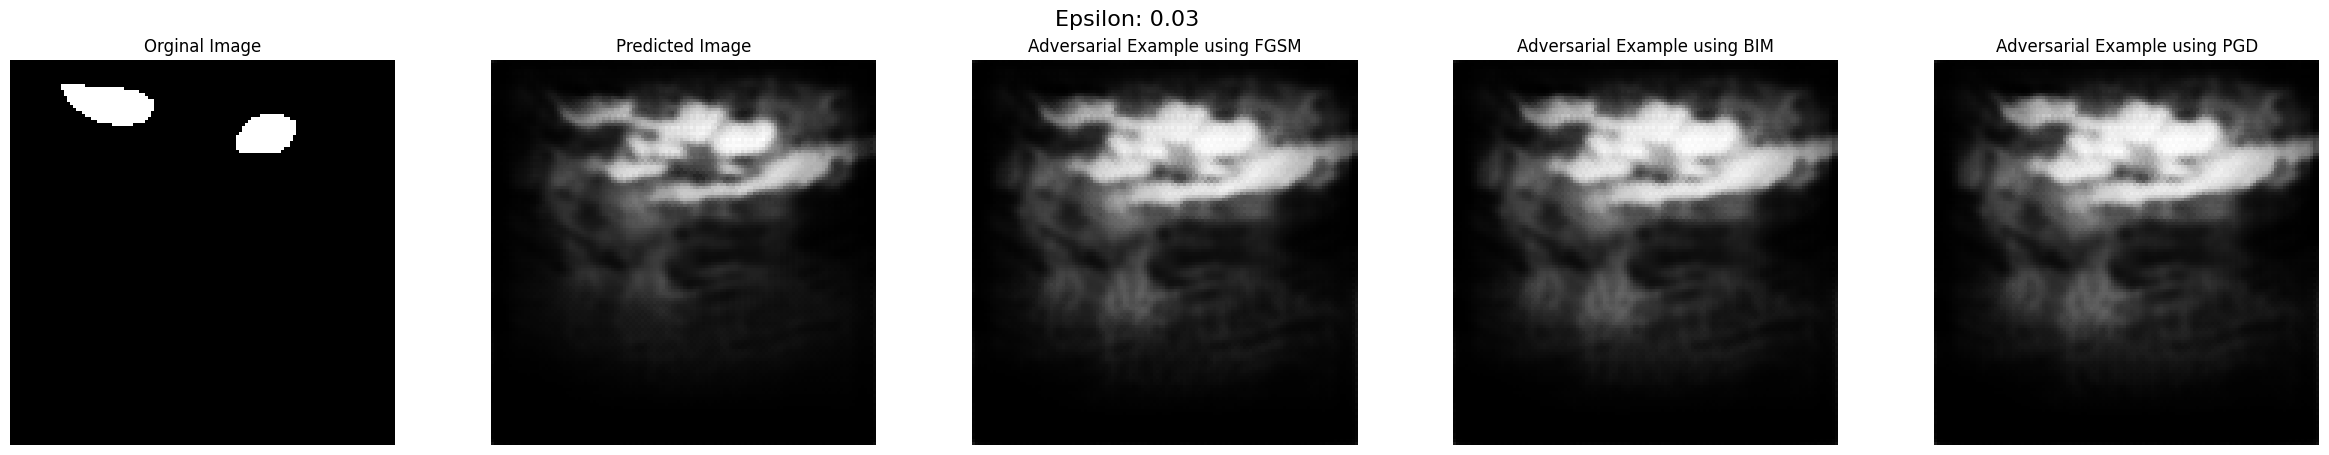

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 66ms/step - loss: 0.2409 - accuracy: 0.9067
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.060207754, shape=(), dtype=float32)
tf.Tensor(0.06368531, shape=(), dtype=float32)
tf.Tensor(0.06736687, shape=(), dtype=float32)
tf.Tensor(0.07119873, shape=(), dtype=float32)
tf.Tensor(0.07520784, shape=(), dtype=float32)
tf.Tensor(0.0793177, shape=(), dtype=float32)
tf.Tensor(0.083576605, shape=(), dtype=float32)
tf.Tensor(0.08799711, shape=(), dtype=float32)
tf.Tensor(0.09262763, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.09653135, shape=(), dtype=float32)
tf.Tensor(0.10060426, shape=(), dtype=float32)
tf.Tensor(0.10490874, shape=(), dtype=float32)
tf.Tensor(0.10952103, shape=(), dtype=float32)
tf.Tensor(0.114446275, shape=(), dtype=float32)
tf.Tensor(0.1

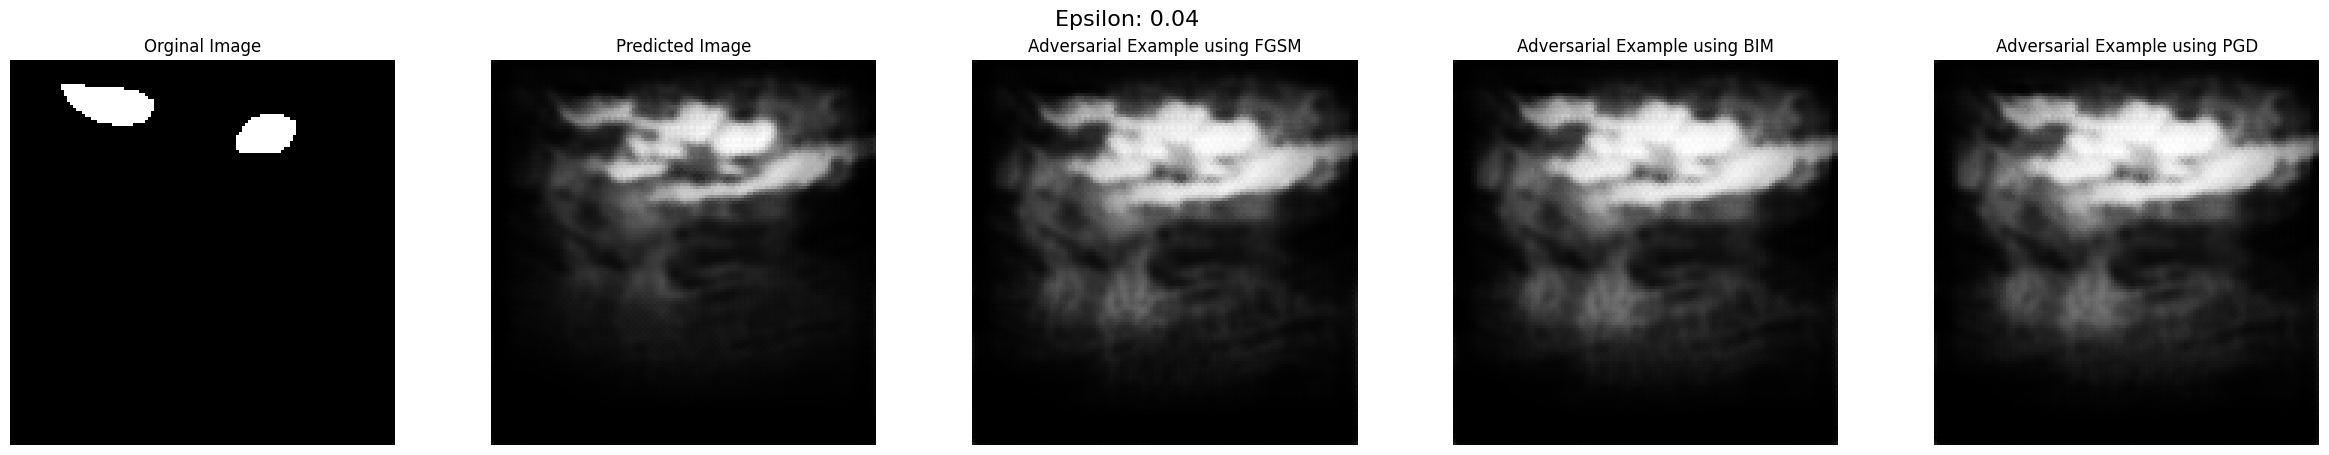

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 65ms/step - loss: 0.2585 - accuracy: 0.8971
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.061036654, shape=(), dtype=float32)
tf.Tensor(0.06547813, shape=(), dtype=float32)
tf.Tensor(0.07019273, shape=(), dtype=float32)
tf.Tensor(0.07514942, shape=(), dtype=float32)
tf.Tensor(0.08030097, shape=(), dtype=float32)
tf.Tensor(0.085682705, shape=(), dtype=float32)
tf.Tensor(0.091340795, shape=(), dtype=float32)
tf.Tensor(0.097384155, shape=(), dtype=float32)
tf.Tensor(0.103899695, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.097520694, shape=(), dtype=float32)
tf.Tensor(0.10270179, shape=(), dtype=float32)
tf.Tensor(0.10830601, shape=(), dtype=float32)
tf.Tensor(0.11438274, shape=(), dtype=float32)
tf.Tensor(0.12097305, shape=(), dtype=float32)
tf.Tensor

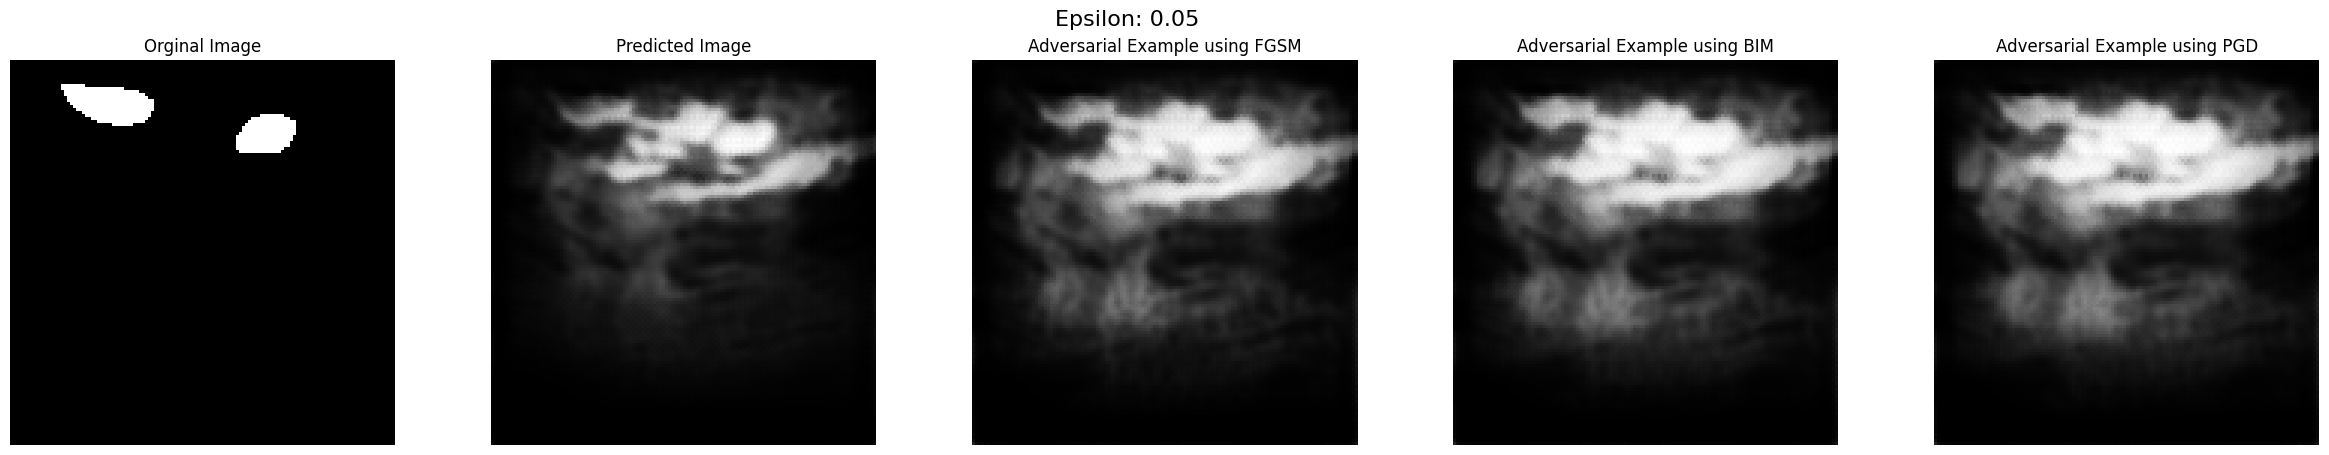

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 65ms/step - loss: 0.2766 - accuracy: 0.8876
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.061878286, shape=(), dtype=float32)
tf.Tensor(0.06730612, shape=(), dtype=float32)
tf.Tensor(0.07310757, shape=(), dtype=float32)
tf.Tensor(0.07921961, shape=(), dtype=float32)
tf.Tensor(0.08564125, shape=(), dtype=float32)
tf.Tensor(0.092467025, shape=(), dtype=float32)
tf.Tensor(0.09979519, shape=(), dtype=float32)
tf.Tensor(0.107899845, shape=(), dtype=float32)
tf.Tensor(0.11672243, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.098515406, shape=(), dtype=float32)
tf.Tensor(0.10485355, shape=(), dtype=float32)
tf.Tensor(0.111838326, shape=(), dtype=float32)
tf.Tensor(0.11954002, shape=(), dtype=float32)
tf.Tensor(0.12800348, shape=(), dtype=float32)
tf.Tensor(

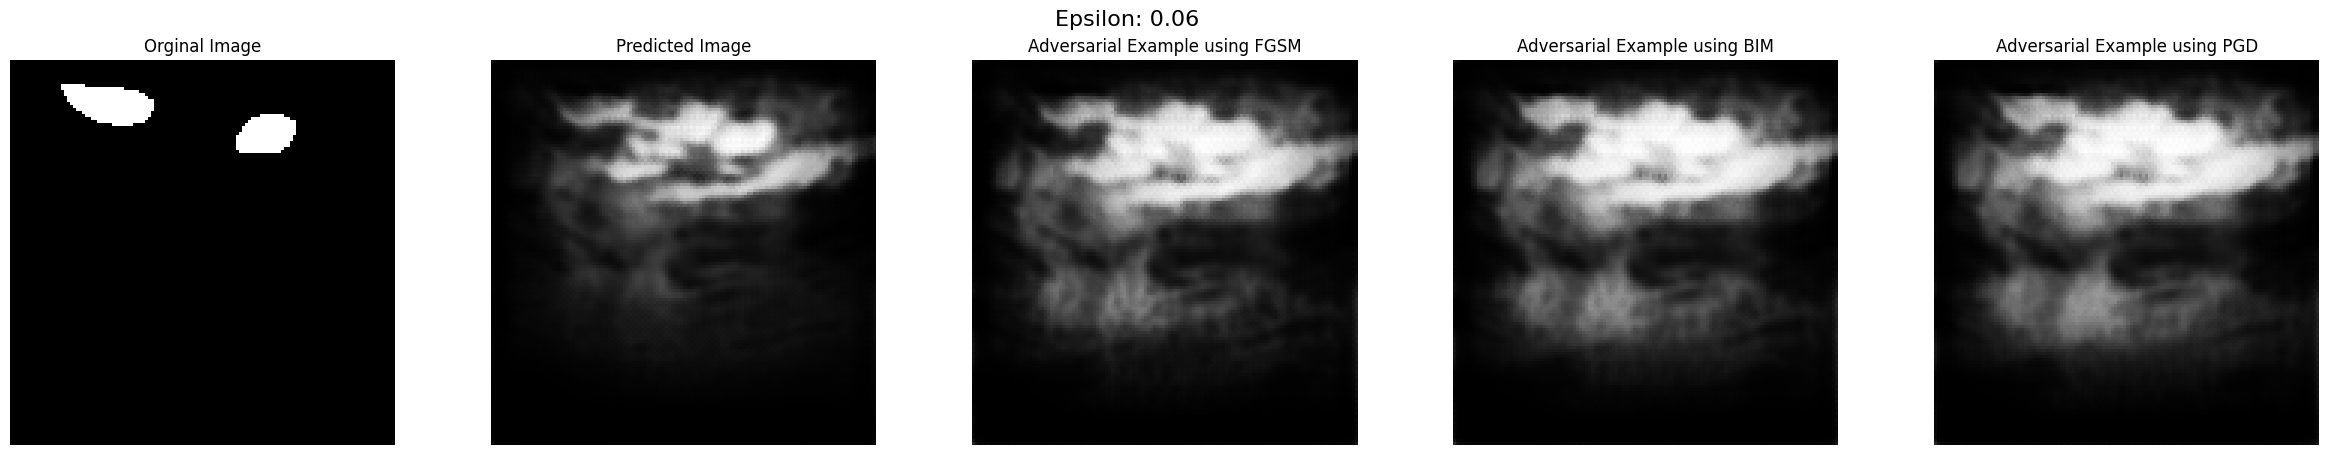

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 69ms/step - loss: 0.2954 - accuracy: 0.8780
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.062734485, shape=(), dtype=float32)
tf.Tensor(0.06916997, shape=(), dtype=float32)
tf.Tensor(0.07606442, shape=(), dtype=float32)
tf.Tensor(0.083357334, shape=(), dtype=float32)
tf.Tensor(0.091168195, shape=(), dtype=float32)
tf.Tensor(0.09966554, shape=(), dtype=float32)
tf.Tensor(0.109126315, shape=(), dtype=float32)
tf.Tensor(0.11958105, shape=(), dtype=float32)
tf.Tensor(0.1310262, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.09951608, shape=(), dtype=float32)
tf.Tensor(0.1070714, shape=(), dtype=float32)
tf.Tensor(0.11553194, shape=(), dtype=float32)
tf.Tensor(0.12502024, shape=(), dtype=float32)
tf.Tensor(0.13560696, shape=(), dtype=float32)
tf.Tensor(0.1

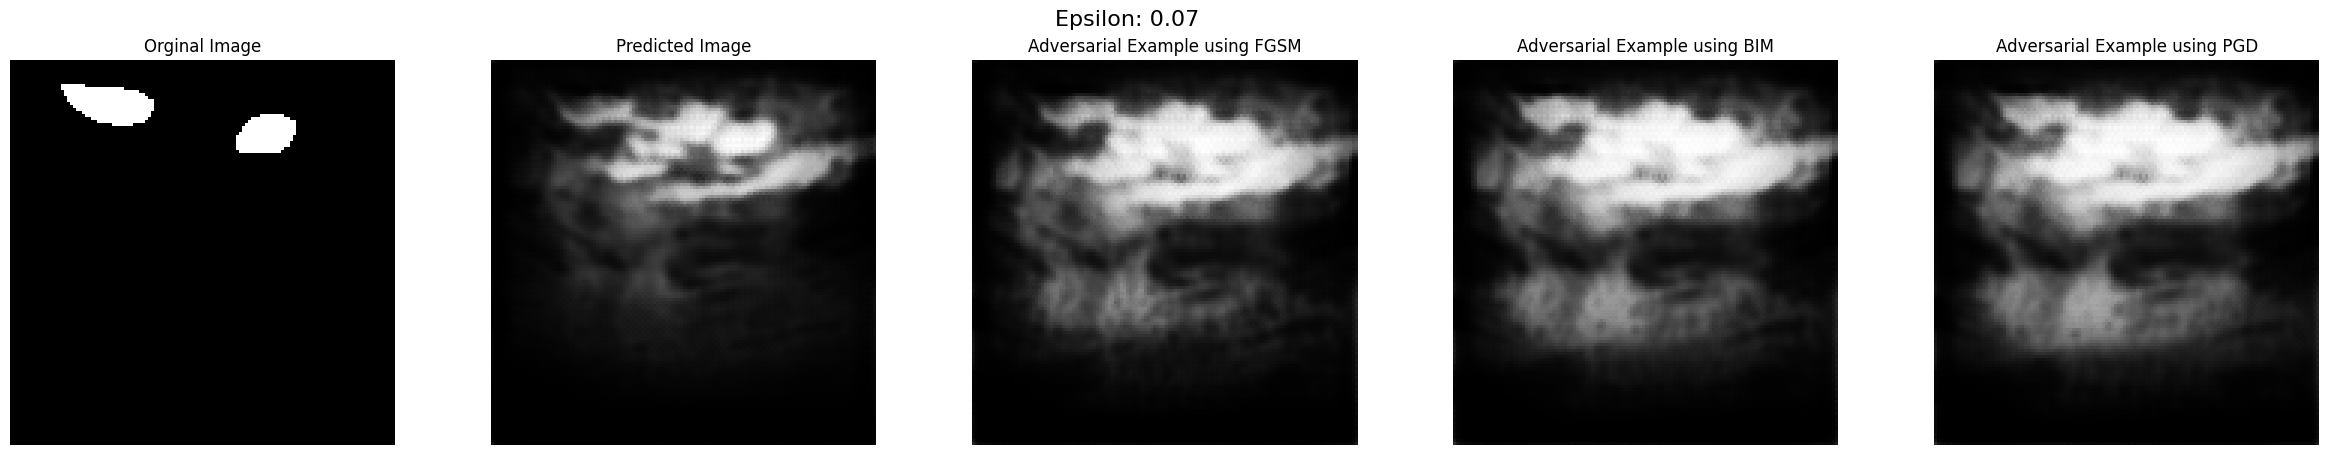

In [ ]:
# Data points for the three methods
perturbation_2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
FGSM_loss_2 = []
PGD_loss_2 = []
BIM_loss_2 = []
FGSM_accuracy_2 = []
PGD_accuracy_2 = []
BIM_accuracy_2 = []
for i in perturbation_2:

  _fgsm = FGSM_attack(model, X_test,y_test,epsilon=i)
  loss, accuracy=model.evaluate(_fgsm ,y_test )
  FGSM_accuracy_2.append(accuracy)
  FGSM_loss_2.append(loss)

  _bim = bim_attack(model, X_test,y_test,epsilon=i, num_steps=10)
  loss, accuracy=model.evaluate(_bim ,y_test )
  BIM_accuracy_2.append(accuracy)
  BIM_loss_2.append(loss)

  _pgd = pgd_attack(model, X_test,y_test,epsilon=i, num_steps=10)
  loss, accuracy=model.evaluate(_pgd ,y_test )
  PGD_accuracy_2.append(accuracy)
  PGD_loss_2.append(loss)

  ploting_all(_fgsm,_bim,_pgd,X_test,i)

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 66ms/step - loss: 0.3570 - accuracy: 0.8465
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.06534879, shape=(), dtype=float32)
tf.Tensor(0.07485095, shape=(), dtype=float32)
tf.Tensor(0.08522162, shape=(), dtype=float32)
tf.Tensor(0.09672746, shape=(), dtype=float32)
tf.Tensor(0.10985489, shape=(), dtype=float32)
tf.Tensor(0.12519547, shape=(), dtype=float32)
tf.Tensor(0.14276792, shape=(), dtype=float32)
tf.Tensor(0.16349845, shape=(), dtype=float32)
tf.Tensor(0.18707493, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.10257052, shape=(), dtype=float32)
tf.Tensor(0.114062145, shape=(), dtype=float32)
tf.Tensor(0.12758245, shape=(), dtype=float32)
tf.Tensor(0.14352667, shape=(), dtype=float32)
tf.Tensor(0.16239515, shape=(), dtype=float32)
tf.Tensor(0.18

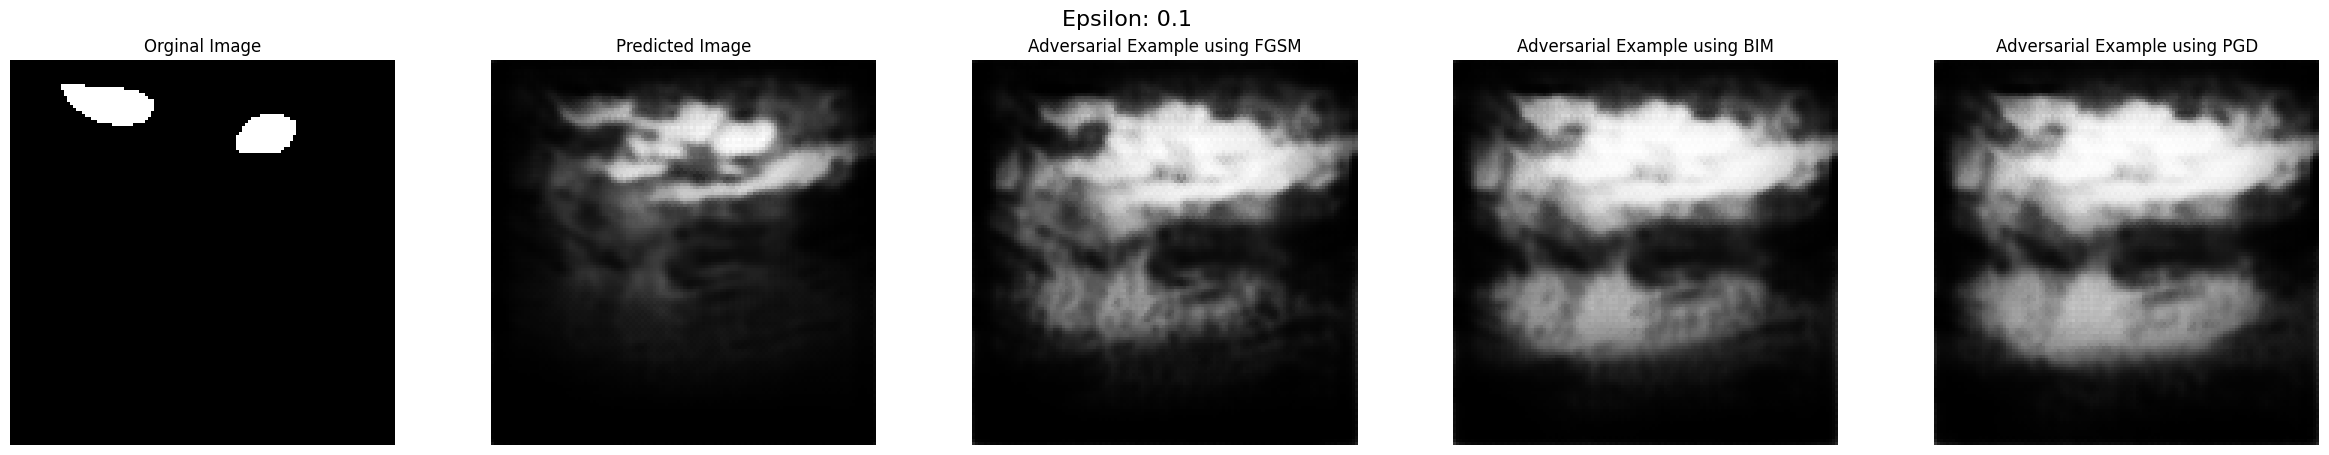

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 66ms/step - loss: 0.5913 - accuracy: 0.7423
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.07438661, shape=(), dtype=float32)
tf.Tensor(0.09562111, shape=(), dtype=float32)
tf.Tensor(0.12289044, shape=(), dtype=float32)
tf.Tensor(0.16008338, shape=(), dtype=float32)
tf.Tensor(0.20877746, shape=(), dtype=float32)
tf.Tensor(0.2723219, shape=(), dtype=float32)
tf.Tensor(0.3470912, shape=(), dtype=float32)
tf.Tensor(0.43182766, shape=(), dtype=float32)
tf.Tensor(0.5196721, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.11353257, shape=(), dtype=float32)
tf.Tensor(0.14207378, shape=(), dtype=float32)
tf.Tensor(0.18120587, shape=(), dtype=float32)
tf.Tensor(0.2329021, shape=(), dtype=float32)
tf.Tensor(0.296022, shape=(), dtype=float32)
tf.Tensor(0.3717884, 

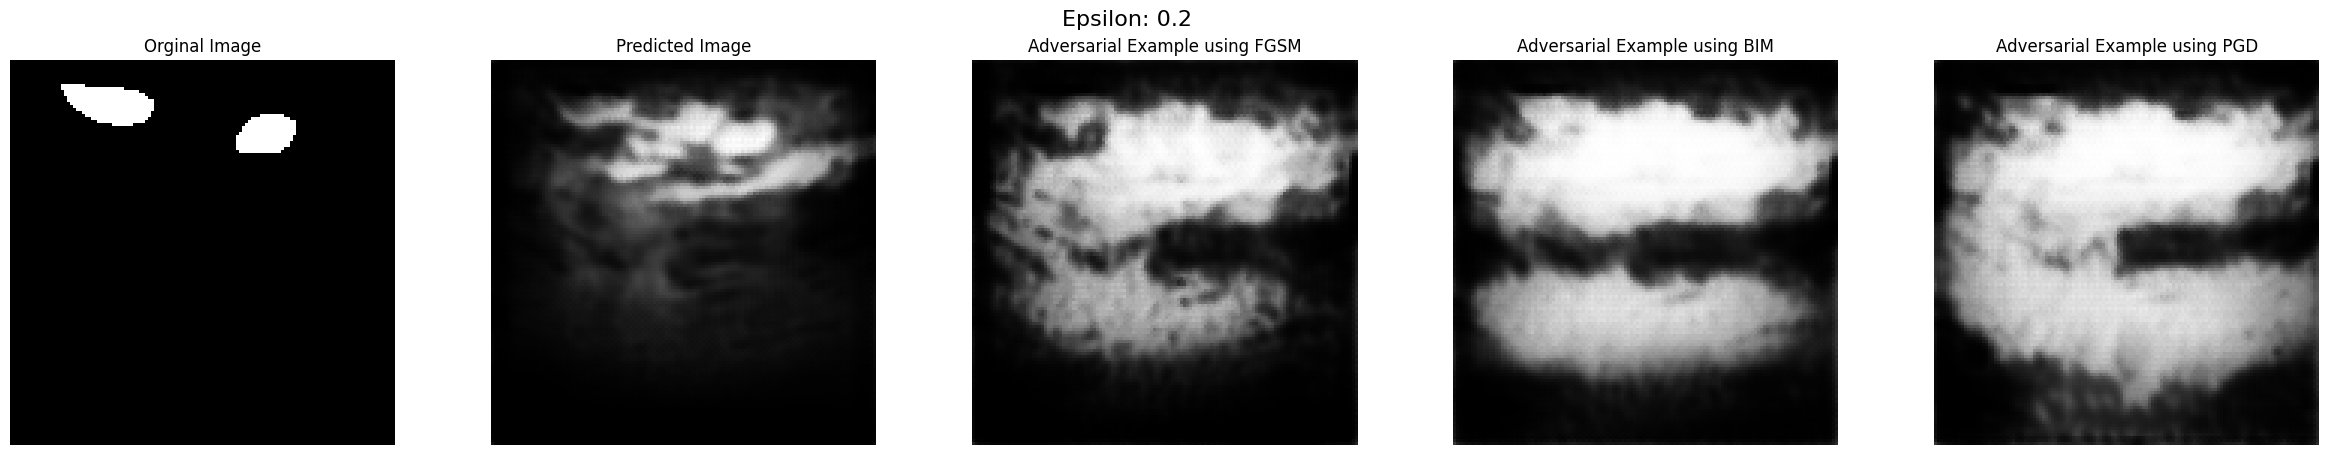

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 65ms/step - loss: 0.7995 - accuracy: 0.6828
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.0836937, shape=(), dtype=float32)
tf.Tensor(0.12104723, shape=(), dtype=float32)
tf.Tensor(0.17874987, shape=(), dtype=float32)
tf.Tensor(0.26695633, shape=(), dtype=float32)
tf.Tensor(0.38220605, shape=(), dtype=float32)
tf.Tensor(0.51715076, shape=(), dtype=float32)
tf.Tensor(0.66226023, shape=(), dtype=float32)
tf.Tensor(0.8112025, shape=(), dtype=float32)
tf.Tensor(0.9765667, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.1256196, shape=(), dtype=float32)
tf.Tensor(0.17847326, shape=(), dtype=float32)
tf.Tensor(0.25824338, shape=(), dtype=float32)
tf.Tensor(0.36205655, shape=(), dtype=float32)
tf.Tensor(0.4865923, shape=(), dtype=float32)
tf.Tensor(0.62609786

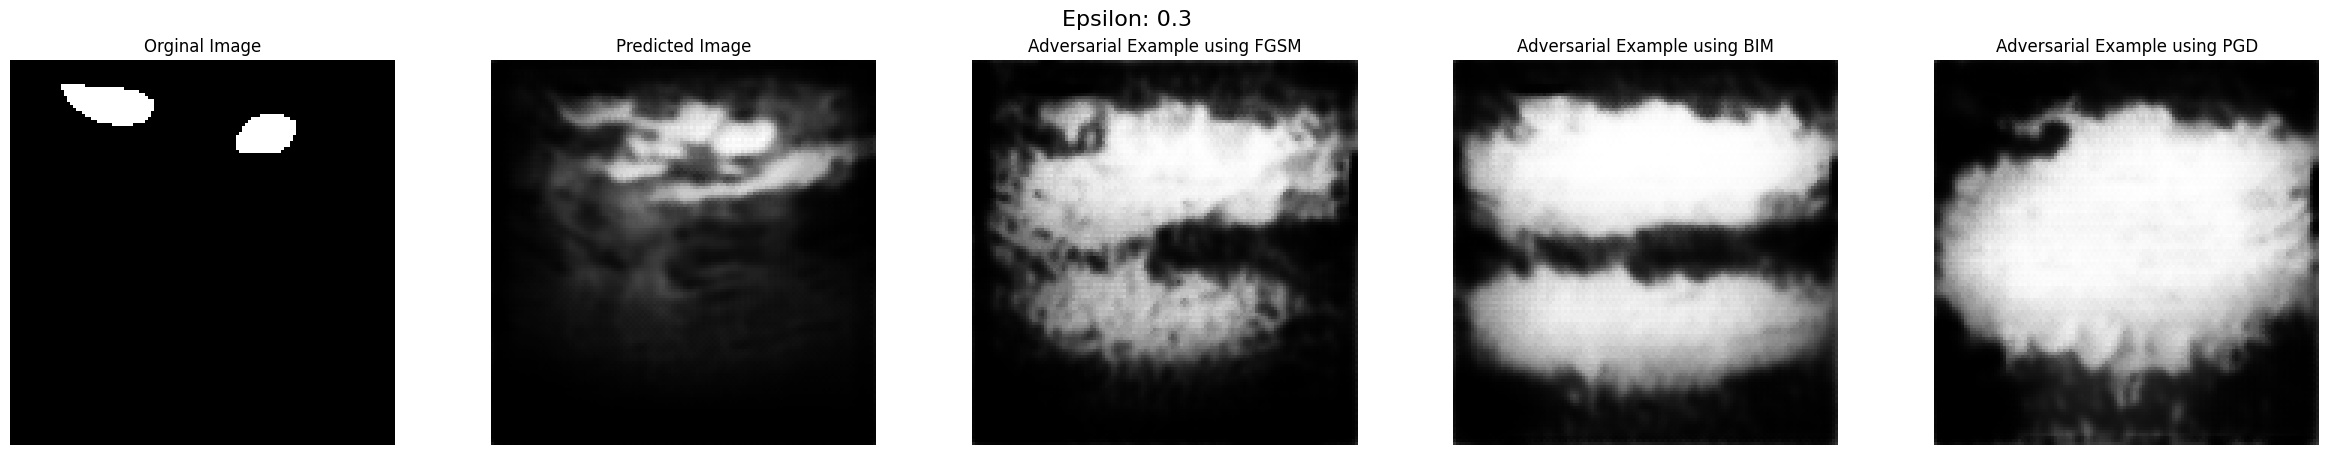

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 66ms/step - loss: 0.9539 - accuracy: 0.6567
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.093461335, shape=(), dtype=float32)
tf.Tensor(0.15328959, shape=(), dtype=float32)
tf.Tensor(0.2627246, shape=(), dtype=float32)
tf.Tensor(0.41699147, shape=(), dtype=float32)
tf.Tensor(0.59809184, shape=(), dtype=float32)
tf.Tensor(0.80120385, shape=(), dtype=float32)
tf.Tensor(1.0102875, shape=(), dtype=float32)
tf.Tensor(1.214335, shape=(), dtype=float32)
tf.Tensor(1.4086914, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.13919428, shape=(), dtype=float32)
tf.Tensor(0.22372176, shape=(), dtype=float32)
tf.Tensor(0.35282773, shape=(), dtype=float32)
tf.Tensor(0.51484036, shape=(), dtype=float32)
tf.Tensor(0.7004886, shape=(), dtype=float32)
tf.Tensor(0.8862117,

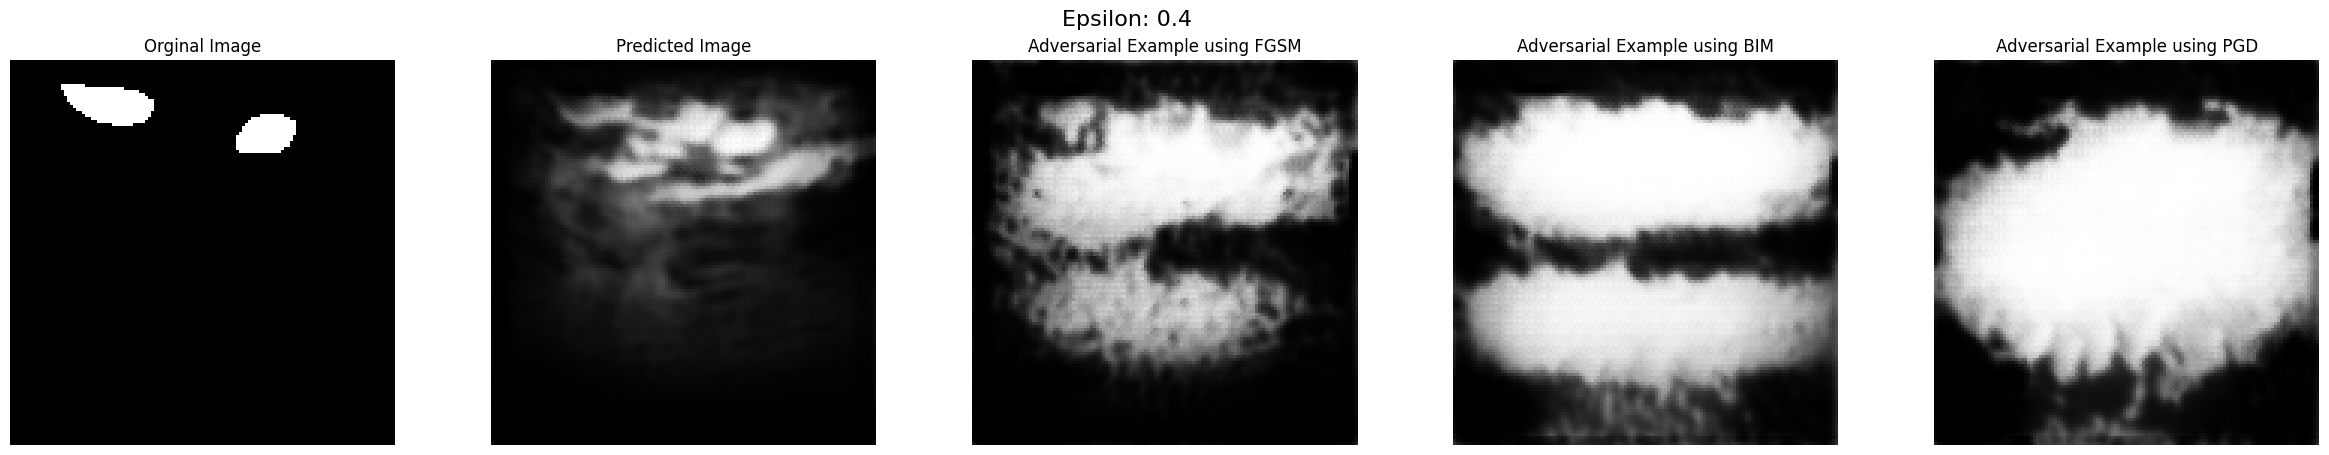

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 66ms/step - loss: 1.0609 - accuracy: 0.6485
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.1040898, shape=(), dtype=float32)
tf.Tensor(0.19479966, shape=(), dtype=float32)
tf.Tensor(0.36227977, shape=(), dtype=float32)
tf.Tensor(0.58533454, shape=(), dtype=float32)
tf.Tensor(0.82777417, shape=(), dtype=float32)
tf.Tensor(1.0999578, shape=(), dtype=float32)
tf.Tensor(1.3269616, shape=(), dtype=float32)
tf.Tensor(1.5356567, shape=(), dtype=float32)
tf.Tensor(1.7215147, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.15441304, shape=(), dtype=float32)
tf.Tensor(0.27753857, shape=(), dtype=float32)
tf.Tensor(0.46255484, shape=(), dtype=float32)
tf.Tensor(0.6936821, shape=(), dtype=float32)
tf.Tensor(0.92574924, shape=(), dtype=float32)
tf.Tensor(1.1814854, 

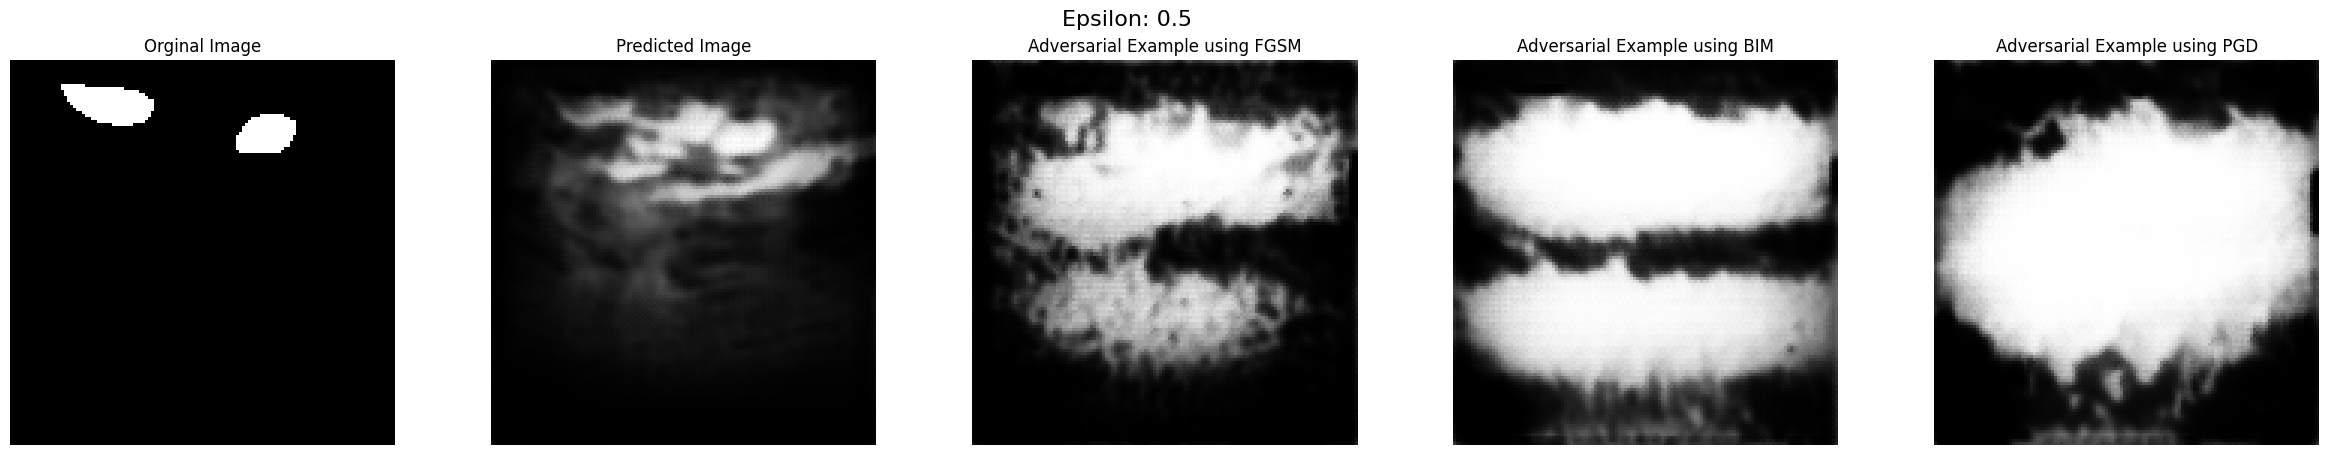

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 66ms/step - loss: 1.1464 - accuracy: 0.6424
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.1156287, shape=(), dtype=float32)
tf.Tensor(0.24813896, shape=(), dtype=float32)
tf.Tensor(0.4831829, shape=(), dtype=float32)
tf.Tensor(0.76856446, shape=(), dtype=float32)
tf.Tensor(1.0769572, shape=(), dtype=float32)
tf.Tensor(1.3531921, shape=(), dtype=float32)
tf.Tensor(1.5846863, shape=(), dtype=float32)
tf.Tensor(1.7799501, shape=(), dtype=float32)
tf.Tensor(1.9660499, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.17126071, shape=(), dtype=float32)
tf.Tensor(0.33879524, shape=(), dtype=float32)
tf.Tensor(0.5781779, shape=(), dtype=float32)
tf.Tensor(0.8696724, shape=(), dtype=float32)
tf.Tensor(1.1377378, shape=(), dtype=float32)
tf.Tensor(1.3995713, shap

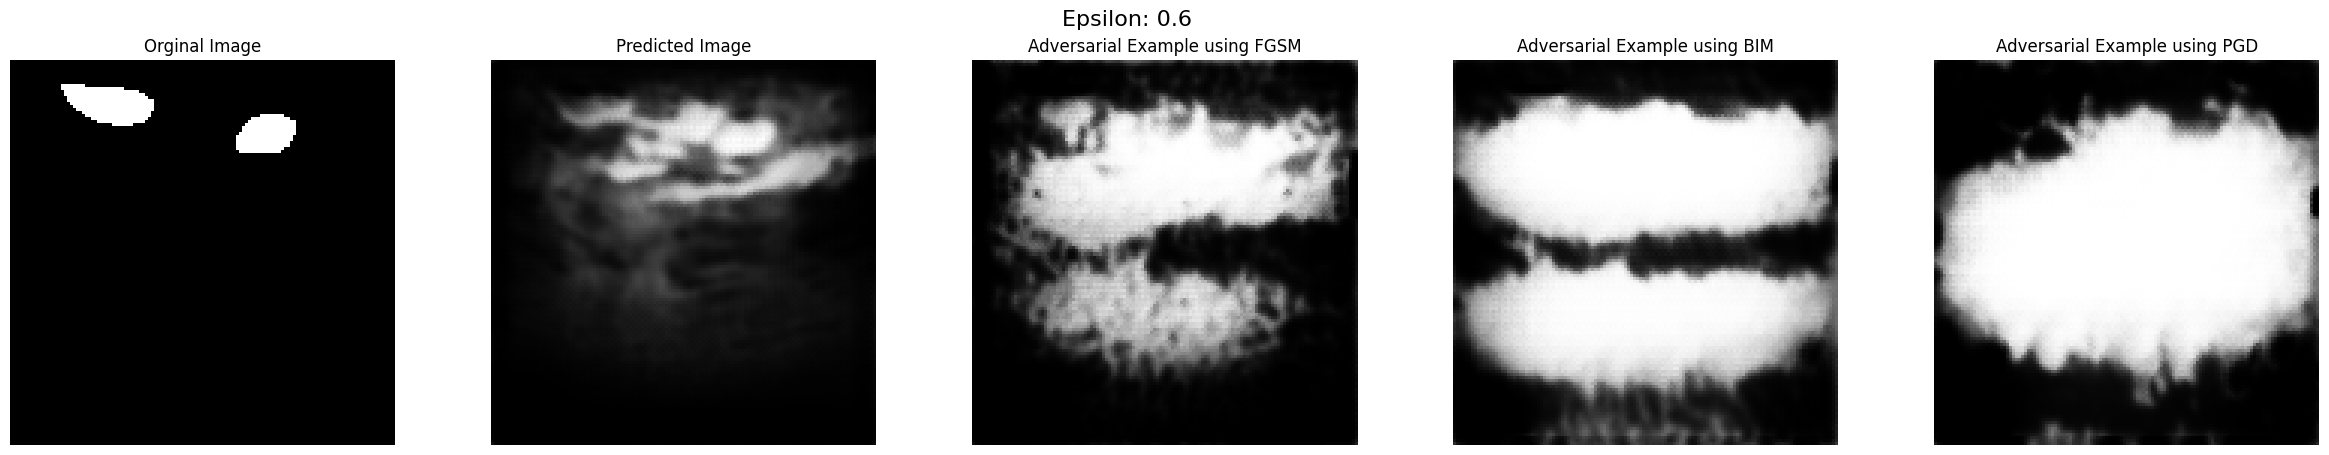

[==================================================] 65 FGSM Attacked!
Done!
3/3 [==============================] - 0s 70ms/step - loss: 1.2101 - accuracy: 0.6395
tf.Tensor(0.056979675, shape=(), dtype=float32)
tf.Tensor(0.12843086, shape=(), dtype=float32)
tf.Tensor(0.3096767, shape=(), dtype=float32)
tf.Tensor(0.6152279, shape=(), dtype=float32)
tf.Tensor(0.96115375, shape=(), dtype=float32)
tf.Tensor(1.2856464, shape=(), dtype=float32)
tf.Tensor(1.5305965, shape=(), dtype=float32)
tf.Tensor(1.7879703, shape=(), dtype=float32)
tf.Tensor(1.9740882, shape=(), dtype=float32)
tf.Tensor(2.17728, shape=(), dtype=float32)
[                                                  ] 1 BIM Attacked!tf.Tensor(0.092655346, shape=(), dtype=float32)
tf.Tensor(0.189871, shape=(), dtype=float32)
tf.Tensor(0.40501744, shape=(), dtype=float32)
tf.Tensor(0.70383567, shape=(), dtype=float32)
tf.Tensor(1.0302205, shape=(), dtype=float32)
tf.Tensor(1.3195072, shape=(), dtype=float32)
tf.Tensor(1.6074488, shape=(

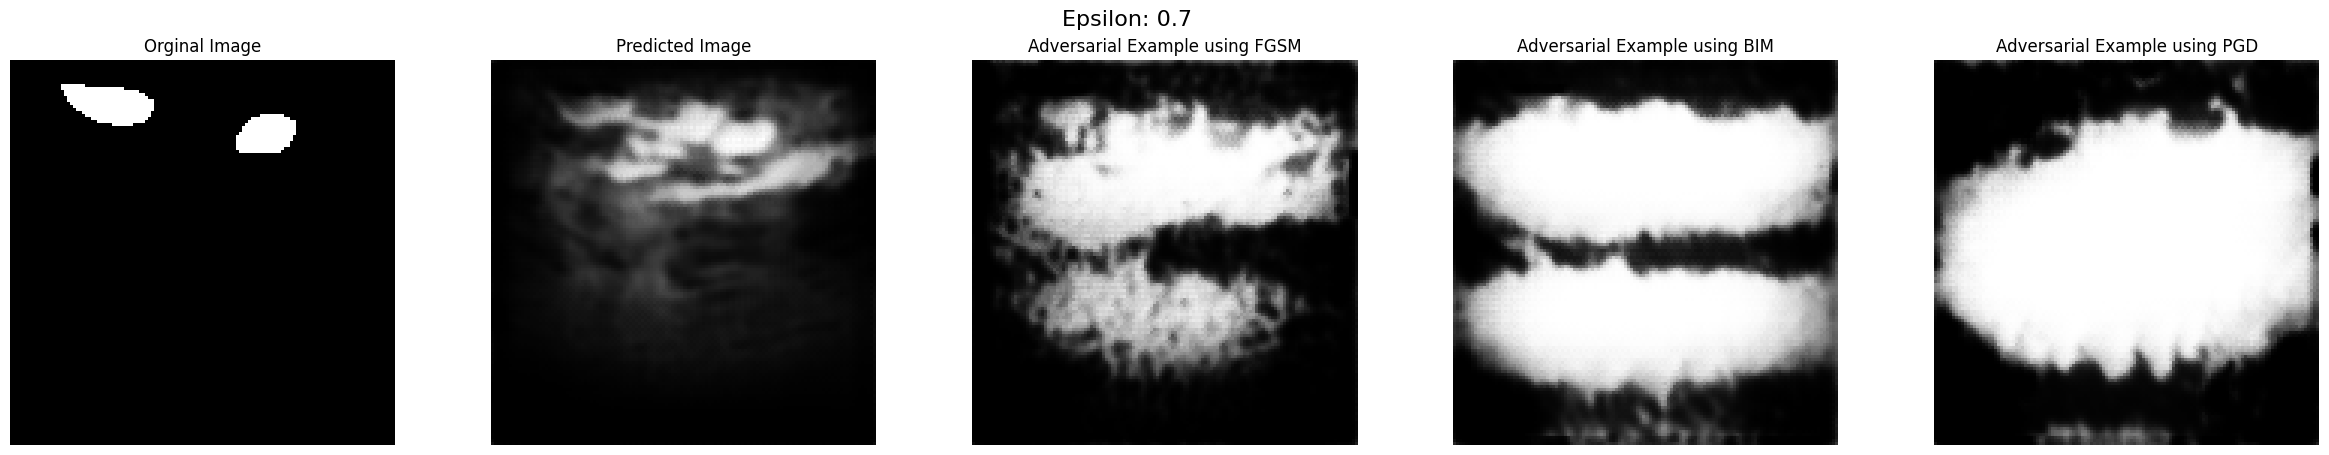

In [ ]:
# Data points for the three methods
perturbation_1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
FGSM_loss_1 = []
PGD_loss_1 = []
BIM_loss_1 = []
FGSM_accuracy_1 = []
PGD_accuracy_1 = []
BIM_accuracy_1 = []
for i in perturbation_1:

  _fgsm = FGSM_attack(model, X_test,y_test,epsilon=i)
  loss, accuracy=model.evaluate(_fgsm ,y_test )
  FGSM_accuracy_1.append(accuracy)
  FGSM_loss_1.append(loss)

  _bim = bim_attack(model, X_test,y_test,epsilon=i, num_steps=10)
  loss, accuracy=model.evaluate(_bim ,y_test )
  BIM_accuracy_1.append(accuracy)
  BIM_loss_1.append(loss)

  _pgd = pgd_attack(model, X_test,y_test,epsilon=i, num_steps=10)
  loss, accuracy=model.evaluate(_pgd ,y_test )
  PGD_accuracy_1.append(accuracy)
  PGD_loss_1.append(loss)

  ploting_all(_fgsm,_bim,_pgd,X_test,i)

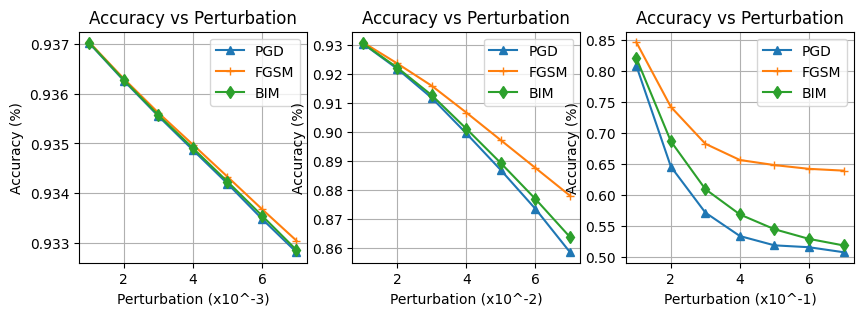

In [ ]:
import matplotlib.pyplot as plt
perturbation=[1,2,3,4,5,6,7]
fig, ax = plt.subplots(1, 3, figsize=(10,3))


ax[0].plot(perturbation, PGD_accuracy_3, marker='^', label='PGD')
ax[0].plot(perturbation, FGSM_accuracy_3, marker='+', label='FGSM')
ax[0].plot(perturbation, BIM_accuracy_3, marker='d', label='BIM')

# Adding labels and title
ax[0].set_xlabel('Perturbation (x10^-3)')  # Use set_xlabel instead of xlabel
ax[0].set_ylabel('Accuracy (%)')           # Use set_ylabel instead of ylabel
ax[0].set_title('Accuracy vs Perturbation')# Use set_title instead of title
ax[0].grid(True)
ax[0].legend()

# Plotting the lines
ax[1].plot(perturbation, PGD_accuracy_2, marker='^', label='PGD')
ax[1].plot(perturbation, FGSM_accuracy_2, marker='+', label='FGSM')
ax[1].plot(perturbation, BIM_accuracy_2, marker='d', label='BIM')

# Adding labels and title
ax[1].set_xlabel('Perturbation (x10^-2)')  # Use set_xlabel instead of xlabel
ax[1].set_ylabel('Accuracy (%)')           # Use set_ylabel instead of ylabel
ax[1].set_title('Accuracy vs Perturbation')# Use set_title instead of title
ax[1].grid(True)
ax[1].legend()

ax[2].plot(perturbation, PGD_accuracy_1, marker='^', label='PGD')
ax[2].plot(perturbation, FGSM_accuracy_1, marker='+', label='FGSM')
ax[2].plot(perturbation, BIM_accuracy_1, marker='d', label='BIM')

# Adding labels and title
ax[2].set_xlabel('Perturbation (x10^-1)')  # Use set_xlabel instead of xlabel
ax[2].set_ylabel('Accuracy (%)')           # Use set_ylabel instead of ylabel
ax[2].set_title('Accuracy vs Perturbation')# Use set_title instead of title
ax[2].grid(True)
ax[2].legend()

# Display the plot
plt.show()


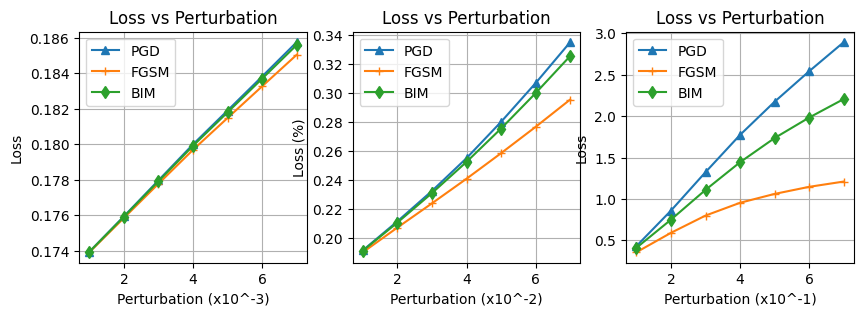

In [ ]:
import matplotlib.pyplot as plt
perturbation=[1,2,3,4,5,6,7]
fig, ax = plt.subplots(1, 3, figsize=(10,3))

ax[0].plot(perturbation, PGD_loss_3, marker='^', label='PGD')
ax[0].plot(perturbation, FGSM_loss_3, marker='+', label='FGSM')
ax[0].plot(perturbation, BIM_loss_3, marker='d', label='BIM')

# Adding labels and title
ax[0].set_xlabel('Perturbation (x10^-3)')  # Use set_xlabel instead of xlabel
ax[0].set_ylabel('Loss')           # Use set_ylabel instead of ylabel
ax[0].set_title('Loss vs Perturbation')# Use set_title instead of title
ax[0].grid(True)
ax[0].legend()



ax[1].plot(perturbation, PGD_loss_2, marker='^', label='PGD')
ax[1].plot(perturbation, FGSM_loss_2, marker='+', label='FGSM')
ax[1].plot(perturbation, BIM_loss_2, marker='d', label='BIM')

# Adding labels and title
ax[1].set_xlabel('Perturbation (x10^-2)')  # Use set_xlabel instead of xlabel
ax[1].set_ylabel('Loss (%)')           # Use set_ylabel instead of ylabel
ax[1].set_title('Loss vs Perturbation')# Use set_title instead of title
ax[1].grid(True)
ax[1].legend()




ax[2].plot(perturbation, PGD_loss_1, marker='^', label='PGD')
ax[2].plot(perturbation, FGSM_loss_1, marker='+', label='FGSM')
ax[2].plot(perturbation, BIM_loss_1, marker='d', label='BIM')

# Adding labels and title
ax[2].set_xlabel('Perturbation (x10^-1)')  # Use set_xlabel instead of xlabel
ax[2].set_ylabel('Loss')           # Use set_ylabel instead of ylabel
ax[2].set_title('Loss vs Perturbation')# Use set_title instead of title
ax[2].grid(True)
ax[2].legend()
# Display the plot
plt.show()


In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 75ms/step - loss: 0.1720 - accuracy: 0.9377


[0.17195618152618408, 0.9377253651618958]

In [ ]:
model.evaluate(adversarial_examples_fgsm, y_test)

3/3 [==============================] - 0s 65ms/step - loss: 0.3570 - accuracy: 0.8465


[0.3569938838481903, 0.8465491533279419]

In [ ]:
model.evaluate(adversarial_examples_bim, y_test)

3/3 [==============================] - 0s 64ms/step - loss: 0.4105 - accuracy: 0.8211


[0.4105047583580017, 0.8210599422454834]

In [ ]:
model.evaluate(adversarial_examples_pgd, y_test)

3/3 [==============================] - 0s 65ms/step - loss: 0.4334 - accuracy: 0.8080


[0.43336570262908936, 0.8079843521118164]

<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<a id="8"></a>
# **<div style="padding:10px;color:white;display:fill;border-radius:5px;background-color:#5642C5;font-size:120%;font-family:Verdana;"><center><span> Evaluation of Resilience to Attacking </span></center></div>**

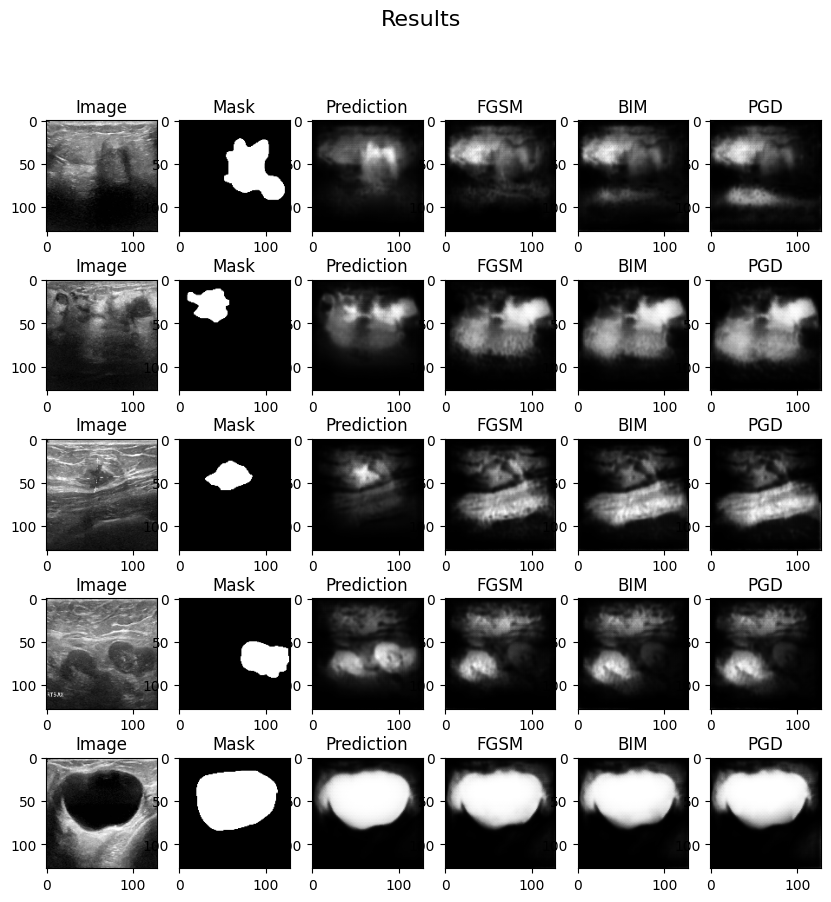

In [ ]:
fig, ax = plt.subplots(5,6, figsize=(10,10))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
    ax[i,3].imshow(model.predict(np.expand_dims(adversarial_examples_fgsm[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,3].set_title('FGSM')
    ax[i,4].imshow(model.predict(np.expand_dims(adversarial_examples_bim[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,4].set_title('BIM')
    ax[i,5].imshow(model.predict(np.expand_dims(adversarial_examples_pgd[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,5].set_title('PGD')
fig.suptitle('Results', fontsize=16)
plt.show()

In [ ]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5
y_pred_fgsm=model.predict(adversarial_examples_fgsm,verbose=0) > 0.5
y_pred_bim=model.predict(adversarial_examples_bim,verbose=0) > 0.5
y_pred_pgd=model.predict(adversarial_examples_pgd,verbose=0) > 0.5
# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU of TEST data =", IOU_keras.result().numpy())
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_fgsm, y_test)
print("Mean IoU of Adversarial Examples using FGSM =", IOU_keras.result().numpy())
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_bim, y_test)
print("Mean IoU of Adversarial Examples using BIM =", IOU_keras.result().numpy())
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_pgd, y_test)
print("Mean IoU of Adversarial Examples using PGD =", IOU_keras.result().numpy())


prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score TEST data= %.3f' % p)
prec_score = Precision()
prec_score.update_state(y_pred_fgsm, y_test)
p = prec_score.result().numpy()
print('Precision Score FGSM = %.3f' % p)
prec_score = Precision()
prec_score.update_state(y_pred_bim, y_test)
p = prec_score.result().numpy()
print('Precision Score BIM = %.3f' % p)
prec_score = Precision()
prec_score.update_state(y_pred_pgd, y_test)
p = prec_score.result().numpy()
print('Precision Score PGD = %.3f' % p)


recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)
f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

recall_score = Recall()
recall_score.update_state(y_pred_fgsm, y_test)
r = recall_score.result().numpy()
print('Recall Score FGSM = %.3f' % r)
f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

recall_score = Recall()
recall_score.update_state(y_pred_bim, y_test)
r = recall_score.result().numpy()
print('Recall Score BIM = %.3f' % r)
f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

recall_score = Recall()
recall_score.update_state(y_pred_pgd, y_test)
r = recall_score.result().numpy()
print('Recall Score PGD = %.3f' % r)
f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)



Mean IoU of TEST data = 0.66656303
Mean IoU of Adversarial Examples using FGSM = 0.48826867
Mean IoU of Adversarial Examples using BIM = 0.4633681
Mean IoU of Adversarial Examples using PGD = 0.4527608
Precision Score TEST data= 0.438
Precision Score FGSM = 0.256
Precision Score BIM = 0.239
Precision Score PGD = 0.236
Recall Score = 0.790
F1 Score = 0.364
Recall Score FGSM = 0.213
F1 Score = 0.224
Recall Score BIM = 0.164
F1 Score = 0.194
Recall Score PGD = 0.148
F1 Score = 0.182


<a href="#ToC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<blockquote><p style="font-size:15px; color:#159364; font-family:verdana;">💬Thank you for reading! If you have any feedback or find anything wrong, please let me know!🙂</p></blockquote>